<a href="https://colab.research.google.com/github/michelleaeh/ADissertation/blob/master/30MScCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project:** MSc in Robotics and Intelligent Systems Dissertation

**Author:** Michelle Alejandra Espinosa Hernandez

**Student registration number:** 1900964

**Student PRID:** ESPIN62803

**Date:** September 2020 

**Purpose:** Obtain classification accuracy among different types of sensors and different data processing steps

# **Data description**

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.

Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.

The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL

If you use this dataset please cite the following papers:

@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}

@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns

**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM


# **Variable definition**

In [1]:
numreps=30      # Number of epochs per word
num_trials=10  # Number of runs of cross validation


# **1. Preparation of data**

**1.1. Start up and initialization of variables**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import random
import scipy as sp
import time
import warnings

from collections import Counter
from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Start timer
starttime = time.time()

# Eliminate warnings
warnings.filterwarnings("ignore")

# Extract all files from zip
with ZipFile("/content/2MyoASL.zip", 'r') as zip:
  zip.extractall()

# Division of sensors
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
     'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']
colnames=emg[:8]+acc[:3]+gyro[:3]+ori[:3]+emg[8:]+acc[3:]+gyro[3:]+ori[3:]

# Words
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']

# Generation of matrices
### Combinations of sensors (E=emg=3, A=acc=5, G=gyro=7, O=ori=11)
comb=['E', 'A', 'G', 'O', 'EA', 'EG', 'EO', 'AG', 'AO', 'GO', 'EAG', 'EAO', 'EGO', 'AGO', 'EAGO'] 
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155] 
### Combinations of steps (N=Normalization=3, S=Standardization=5, B=Butterworth=7, P=PCA=11, V=SVM=13)
nsteps=['V', 'NV', 'SV', 'BV', 'PV', 'NBV', 'NPV', 'SBV', 'SPV', 'BPV', 'NBPV', 'SBPV'] 
steps=[13, 39, 65, 91, 143, 273, 429, 455, 715, 1001, 3003, 5005] 
### Placeholders
fresults=np.zeros((len(steps),len(products)))
params=np.zeros((len(steps),len(products)))
headers=np.empty(1701, dtype=object)
lengths=np.zeros(849, dtype=int)
repsum=np.zeros(37,dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)
fn=np.arange(1701)
matrix=np.zeros(1)
stanproducts=[]
normproducts=[]
regproducts=[]
cmatrix=[]

# Initiation of counters
wordnum=-1
counter=-1
rownum=-1
start=0
num=0
n=0

**1.2. Combine all files**

In [3]:
for w in words:
  repcount=0
  wordnum+=1
  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'
    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      trial.reset_index(drop=True)
      
      # Assign word number to each row and make data horizontal
      row=np.zeros(1)
      for t in range(35):
        if t==0:
          row[0]=wordnum
        else:
          sensor=trial.iloc[0:50,t].values
          sensor.reshape([1,50])
          row=np.concatenate((row, sensor))
      prev=row
      
      # Combine all trials
      if counter==0:
        matrix=prev
      else:
        matrix=np.concatenate([matrix,prev])

  reps[wordnum]=repcount
  if wordnum>0:
    repsum[wordnum]=reps[wordnum-1]+repsum[wordnum-1]
    repsum[36]=849

# Create header name array
headers[0]='Word'
for c in colnames:
  for t in range(50):
    num+=1
    headers[num]=c

# Give format to final matrix 
matrix=matrix.reshape([849,1701])
matrix=pd.DataFrame(matrix, columns=headers)
matrix=pd.concat([matrix['Word'],matrix[emg],matrix[acc],matrix[gyro],matrix[ori]],axis=1)
exec("matrix.to_csv(path_or_buf='/content/complete_matrix_'+str(numreps)+'.csv')")
print('Reps of each word:',reps)
print('Cummulative reps:',repsum)

Reps of each word: [19 24 32 20 24 20 19 31 24 29 20 21 23 33 34 18 27 24 35 19 17 34 30 19
 22 21 23 27 27  4 20 19 20 20 21 29]
Cummulative reps: [  0  19  43  75  95 119 139 158 189 213 242 262 283 306 339 373 391 418
 442 477 496 513 547 577 596 618 639 662 689 716 720 740 759 779 799 820
 849]


**1.3. Calculate mean and standard deviation of each sensor and each file**

In [4]:
# Average and standard deviation of each sensor in each file
for s in colnames:
  avg=matrix[s].mean(axis=1)
  sd=matrix[s].std(axis=1)
  sensor=pd.concat([avg.rename(s+': Mean_'),sd.rename('St. dev.')], axis=1)
  if s=='EMG0L':
    asd=sensor
  else:
    asd=pd.concat([asd, sensor], axis=1)
print('Average and standard deviation of each sensor per file')
print(asd)

# Average and standard deviation of each file
avg=matrix.mean(axis=1)
sd=matrix.std(axis=1)
print('Average and standard deviation of each file')
pd.concat([avg.rename('Mean'),sd.rename('St. dev.')], axis=1)

Average and standard deviation of each sensor per file
     EMG0L: Mean_   St. dev.  EMG1L: Mean_  ...   St. dev.  OYR: Mean_   St. dev.
0           -2.32   8.664825         -0.80  ...  28.427609       86.70  10.529356
1           -1.80   9.544739         -4.08  ...  27.821010       85.68   6.579002
2           -3.16  13.085839         -2.32  ...  30.345736       91.88  17.358924
3           -0.82  10.123099         -3.16  ...  29.645002       88.46  12.969682
4           -0.50   6.516071          2.76  ...  13.237239      116.58  18.099600
..            ...        ...           ...  ...        ...         ...        ...
844          0.56   7.754288          0.22  ...  17.236281      104.76   7.528341
845         -1.74   6.520955         -1.20  ...  21.772891       69.66  85.251036
846          1.02   7.731436          0.46  ...  22.707735       56.76  79.408415
847          0.06   5.582078          2.36  ...  23.650422       71.62  84.238701
848         -2.22   7.434860         -1.62 

,Mean,St. dev.
0,15.256437,46.545832
1,14.220110,47.316822
2,15.441784,45.614456
3,13.651092,47.038916
4,15.063294,49.105612
...,...,...
844,13.167964,41.642351
845,13.815314,42.880121
846,12.970618,42.725653
847,13.852317,43.758631


# **2. Data adjustement**

**2.1. Establish equal number of epochs per word**

In [5]:
for i in range(len(reps)-1,-1,-1):
  if reps[i]<numreps:
    for r in range(len(matrix)-1,-1,-1):
      if int(matrix.iloc[r]['Word'])==i:
        matrix=matrix.drop(r)
  elif reps[i]>numreps:
    elim=random.sample(range(repsum[i],repsum[i+1]),reps[i]-numreps)
    matrix=matrix.drop(elim)

exec("matrix.to_csv(path_or_buf='/content/equal_matrix_'+str(numreps)+'.csv')")

**2.2. Create sensor combinatory matrices: unaltered, normalized, and standardized**

In [6]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  fnword=[]
  fsword=[]
  m=matrix.copy()
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  
  # Separate features from target values
  x = m.iloc[:, m.columns!='Word']   # Features

  # Create column of words instead of numbers
  wordcol=np.empty(len(m), dtype=object)
  z=0
  wcol=[int(i) for i in m['Word'].values]
  for f in wcol:
    wordcol[z]=words[f]
    z+=1
  wordcol=np.asmatrix(wordcol)
  regular=np.concatenate((np.transpose(wordcol),np.copy(m.iloc[:,1:])),axis=1)
  inputmatrix=pd.DataFrame(regular,columns=m.columns).dropna(axis=1)
  regproducts.append(inputmatrix)

  for pr in range(len(inputmatrix)):
    nemg=[]
    nacc=[]
    ngyro=[]
    nori=[]
    norm=[]
    semg=[]
    sacc=[]
    sgyro=[]
    sori=[]
    stan=[]
    if emg[0] in inputmatrix:
      in_emg=inputmatrix.iloc[pr][emg]
      nemg=(in_emg-in_emg.min())/(in_emg.max()-in_emg.min())
      is_emg=inputmatrix.iloc[pr][emg].values
      is_emg=is_emg[np.newaxis]
      semg=StandardScaler().fit_transform(np.transpose(is_emg))
      semg=semg.reshape(-1)
    if acc[0] in inputmatrix:
      in_acc=inputmatrix.iloc[pr][acc]
      nacc=(in_acc-in_acc.min())/(in_acc.max()-in_acc.min())
      is_acc=inputmatrix.iloc[pr][acc].values
      is_acc=is_acc[np.newaxis]
      sacc=StandardScaler().fit_transform(np.transpose(is_acc))
      sacc=sacc.reshape(-1)
    if gyro[0] in inputmatrix:
      in_gyro=inputmatrix.iloc[pr][gyro]
      ngyro=(in_gyro-in_gyro.min())/(in_gyro.max()-in_gyro.min())
      is_gyro=inputmatrix.iloc[pr][gyro].values
      is_gyro=is_gyro[np.newaxis]
      sgyro=StandardScaler().fit_transform(np.transpose(is_gyro))
      sgyro=sgyro.reshape(-1)
    if ori[0] in inputmatrix:
      in_ori=inputmatrix.iloc[pr][ori]
      nori=(in_ori-in_ori.min())/(in_ori.max()-in_ori.min())
      is_ori=inputmatrix.iloc[pr][ori].values
      is_ori=is_ori[np.newaxis]
      sori=StandardScaler().fit_transform(np.transpose(is_ori))
      sori=sori.reshape(-1)
    
    ## Normalize each type of sensor per sample between 0 and 1
    norm=np.concatenate((np.transpose(nemg),np.transpose(nacc),np.transpose(ngyro),np.transpose(nori)))
    norm=norm[np.newaxis]
    fnword=np.append(fnword,norm)
    fnword=fnword[np.newaxis]
    
    ## Standardize each type of sensor with mean=0 and deviation=1
    stan=np.concatenate((np.transpose(semg),np.transpose(sacc),np.transpose(sgyro),np.transpose(sori)))
    stan=stan[np.newaxis]
    fsword=np.append(fsword,stan)
    fsword=fsword[np.newaxis]

  nmx=np.reshape(fnword,(len(inputmatrix),len(inputmatrix.columns)-1))
  norm_matrix=np.concatenate((np.transpose(wordcol),nmx),axis=1) 
  norm_matrix=pd.DataFrame(norm_matrix,columns=inputmatrix.columns).dropna(axis=1)
  normproducts.append(norm_matrix)
  exec("norm_matrix.to_csv(path_or_buf='/content/norm_matrix_'+str(numreps)+'.'+str(v)+'.csv')")

  smx=np.reshape(fsword,(len(inputmatrix),len(inputmatrix.columns)-1))
  stan_matrix=np.concatenate((np.transpose(wordcol),smx),axis=1) 
  stan_matrix=pd.DataFrame(stan_matrix,columns=inputmatrix.columns).dropna(axis=1)
  stanproducts.append(stan_matrix)
  exec("stan_matrix.to_csv(path_or_buf='/content/stan_matrix_'+str(numreps)+'.'+str(v)+'.csv')")


# **3. Definition of functions for steps**

**3.1. Split data into train and test sets**

In [7]:
def datasplit(inmatrix_p):
    x = inmatrix_p.iloc[:, inmatrix_p.columns!='Word']   # Features
    y = inmatrix_p.loc[:,'Word']                         # Target
    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x, y, test_size=0.3)
    return x_train_p, x_test_p, y_train_p, y_test_p

**3.2. Butterworth**

In [8]:
def butterworth(inmatrix_b):
  fs_nyq=50/2
  b, a = sp.signal.butter(8, 20/fs_nyq, btype='highpass', fs=fs_nyq)
  if emg[0] in inmatrix_b:
    for r in range(len(inmatrix_b)):
      in_emg=inmatrix_b.iloc[r][emg].values
      emg_filtered = sp.signal.lfilter(b, a, in_emg)
      emg_filtered=emg_filtered[np.newaxis]
      inmatrix_b.iloc[r,1:len(np.transpose(emg_filtered))+1]=emg_filtered
  return inmatrix_b

**3.3. PCA**

In [9]:
def pca(x_train_c, x_test_c, y_train_c, y_test_c):
  #pca = PCA(n_components=min(len(x_train_c), len(y_train_c)))
  pca = PCA()
  pca.fit(x_train_c)
  x_t_train_pca = pca.transform(x_train_c)
  print(x_train_c)
  print(x_t_train_pca)
  x_t_test_pca = pca.transform(x_test_c)
  return x_train_c, x_test_c, y_train_c, y_test_c, x_t_train_pca, x_t_test_pca

**3.4. SVM with Grid Search**

In [10]:
def svm(x_train_s, x_test_s, y_train_s, y_test_s, x_t_train_s, x_t_test_s,combo):
    #parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10, 100, 1000]}
    svc = SVC(max_iter=1000)
    nested_scores=np.zeros(num_trials)
    for t in range(num_trials):
      inner_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      outer_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      #clf=GridSearchCV(svc,parameters,scoring='accuracy',n_jobs=1,cv=outer_cv)
      clf=svc
      clf.fit(x_t_train_s, y_train_s)
      nested_scores=cross_val_score(clf,x_t_test_s,y_test_s,cv=outer_cv)
      nested_scores[i]=nested_scores.mean()
    y_pred=clf.predict(x_t_test_s)
    
    # Confusion matrix
    plot_confusion_matrix(clf, x_t_test_s, y_test_s, cmap=plt.cm.Blues)
    plt.title(combo)
    plt.show()

    #bestpar=clf.best_params_
    accuracy=nested_scores.mean()
    svmresult=classification_report(y_test_s, y_pred)
    #return svmresult,accuracy, bestpar
    return svmresult,accuracy

# **4. Main code**

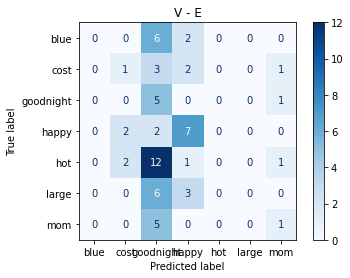

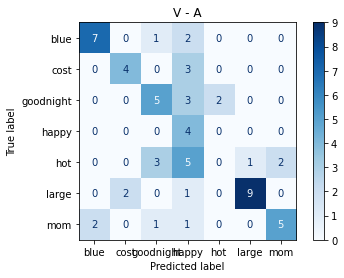

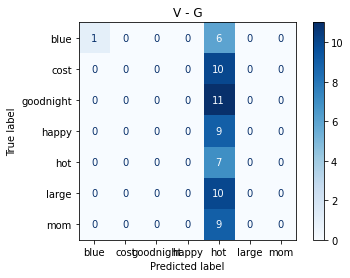

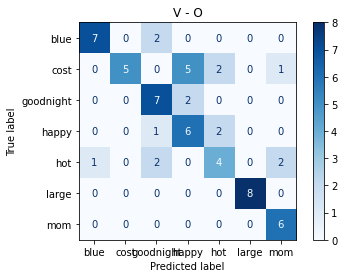

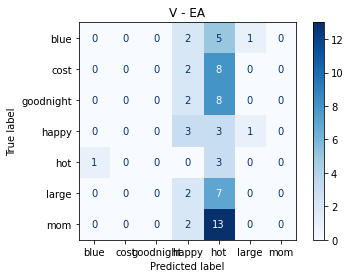

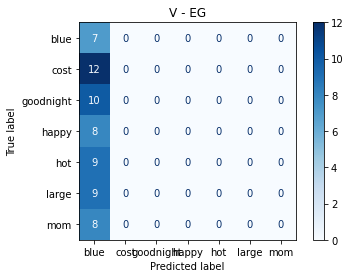

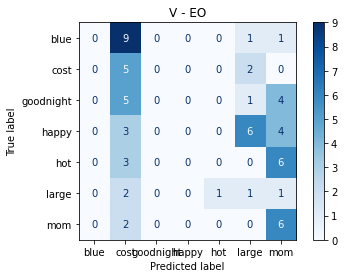

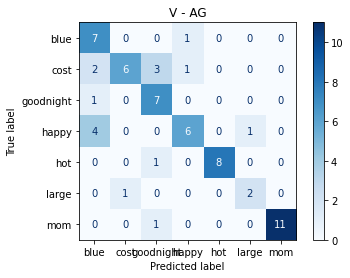

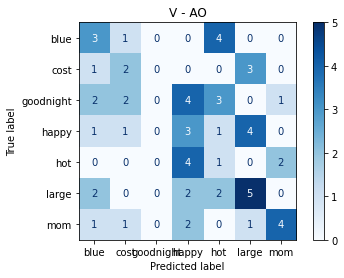

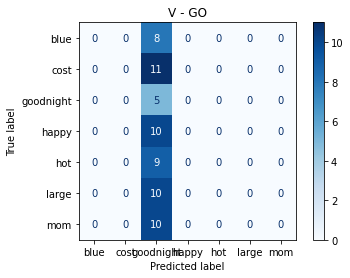

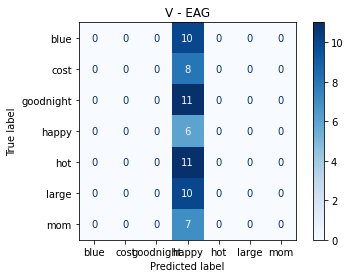

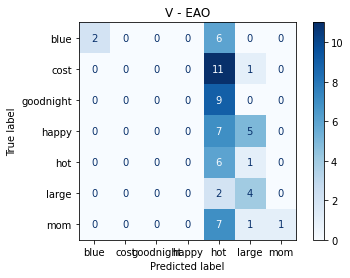

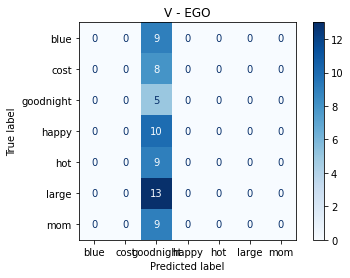

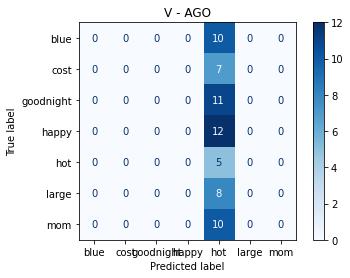

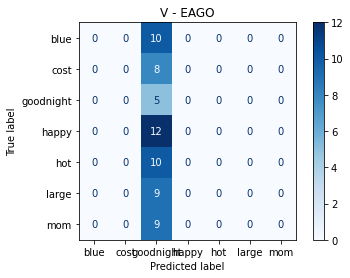

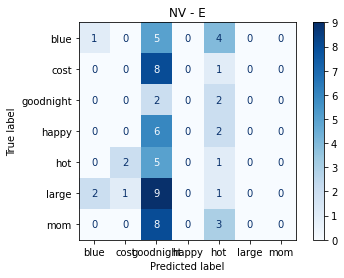

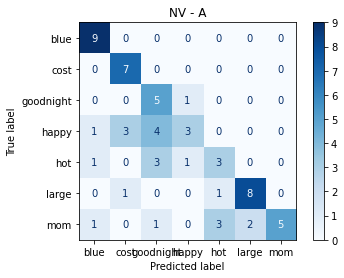

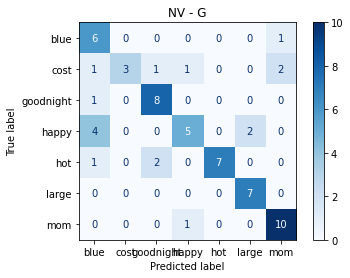

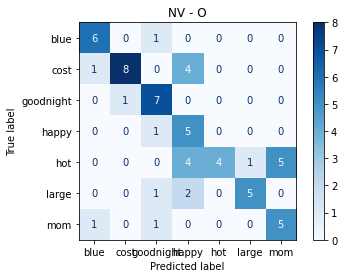

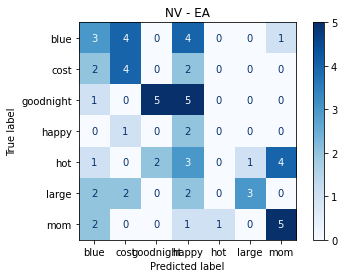

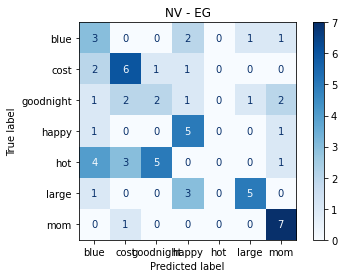

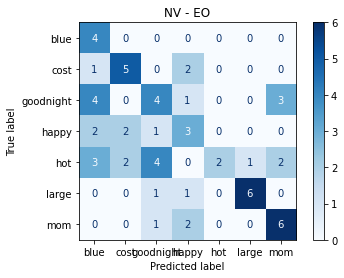

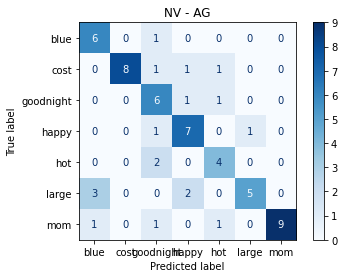

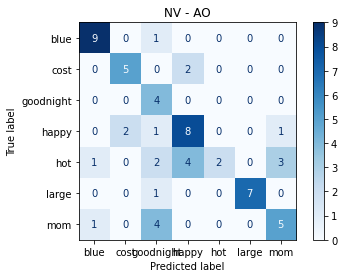

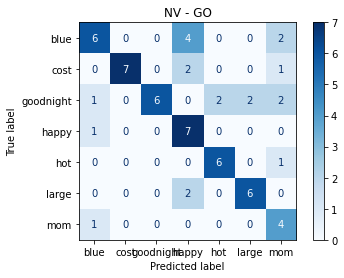

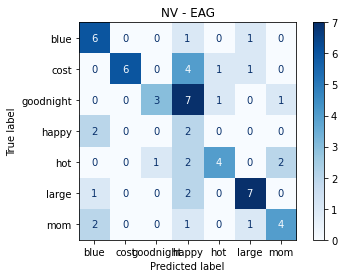

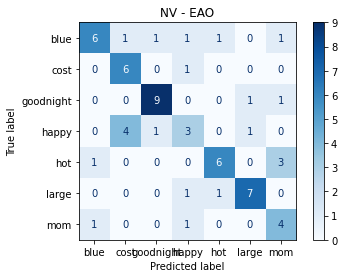

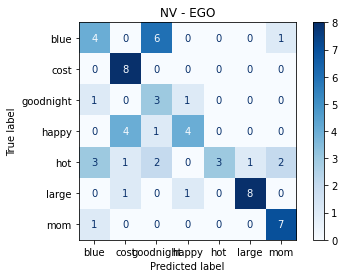

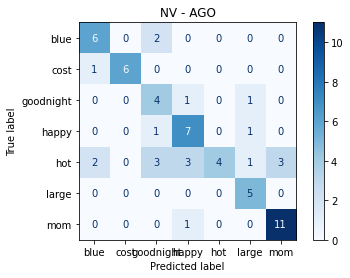

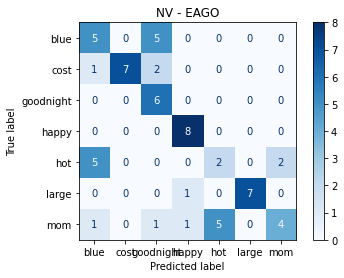

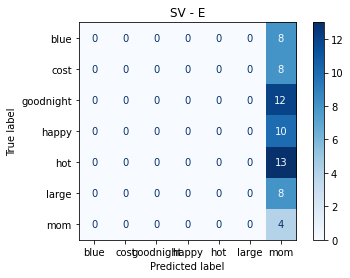

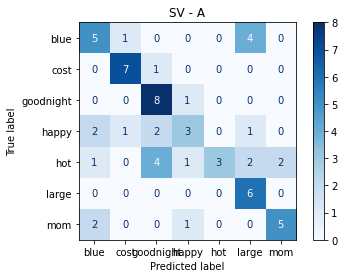

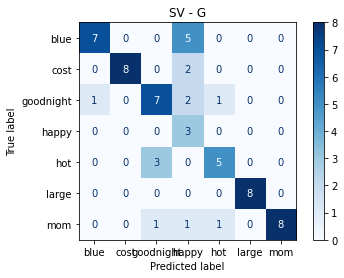

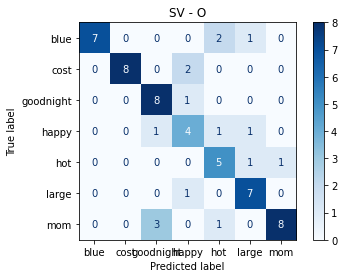

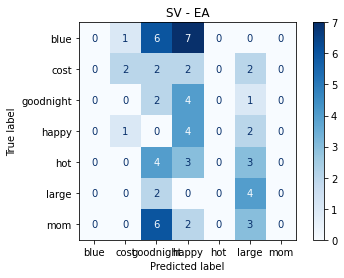

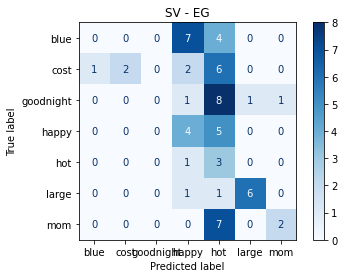

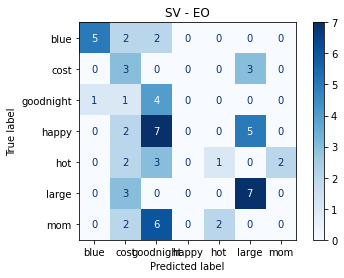

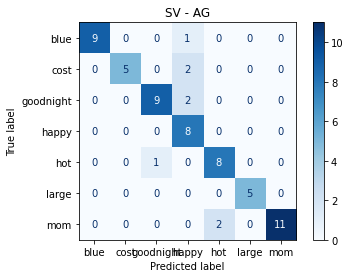

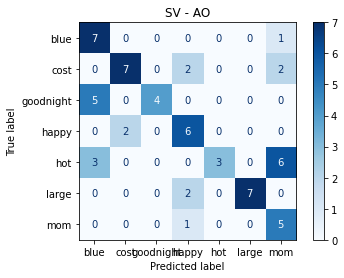

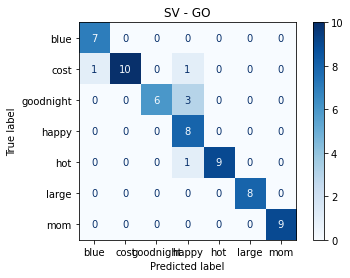

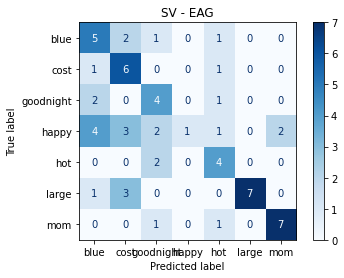

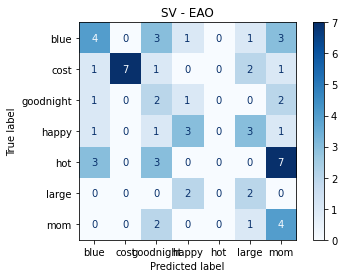

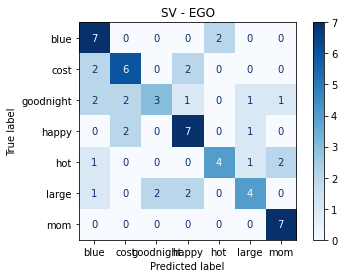

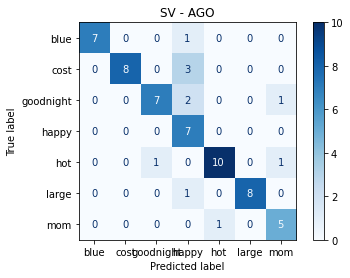

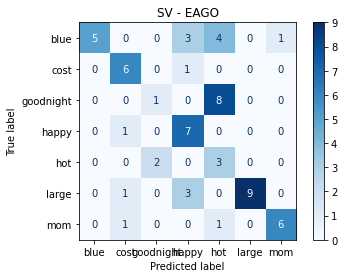

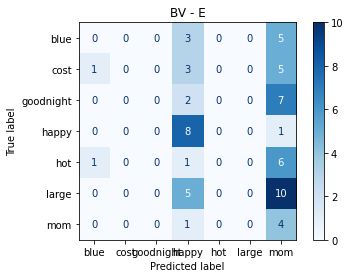

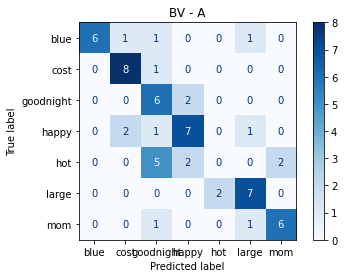

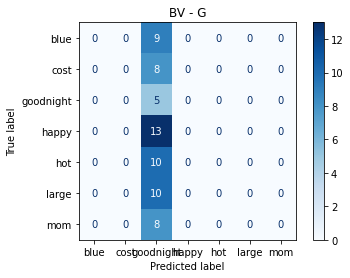

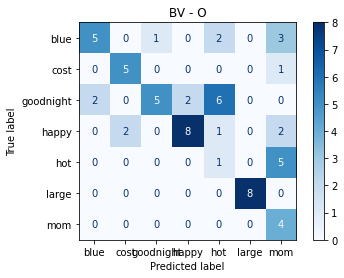

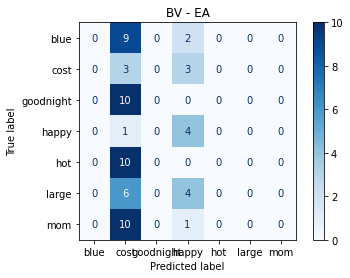

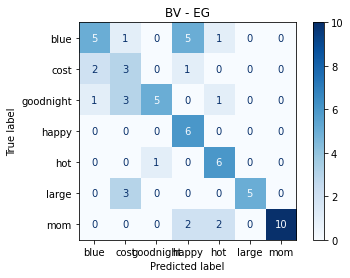

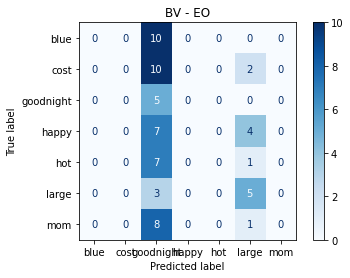

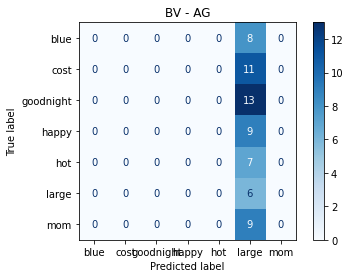

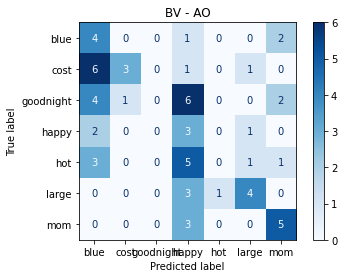

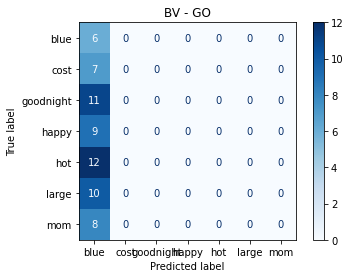

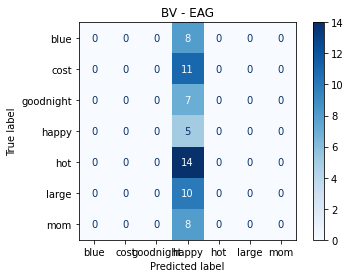

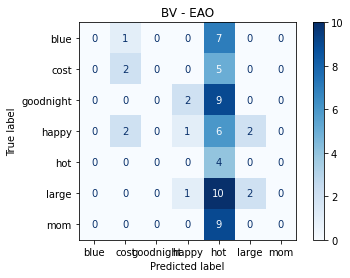

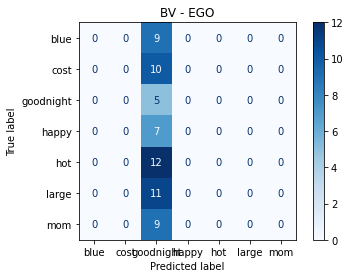

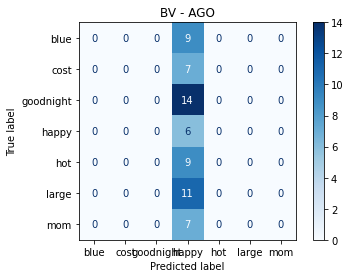

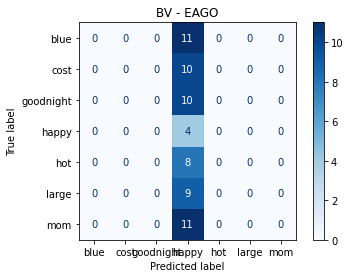

    EMG0L     EMG0L     EMG0L  ...     EMG7R      EMG7R     EMG7R
94      0         0  -2.38658  ...  0.923318    3.70345   2.18086
201     0 -0.596644  0.614797  ...   1.26133   0.425485 -0.773661
4       0  -1.19329  0.632951  ...    1.4755    0.09376 -0.800285
163     0         0   1.19329  ...  -4.49712   -6.12023   1.23472
167     0         0  -2.38658  ...   6.88665    1.81317   19.4713
..    ...       ...       ...  ...       ...        ...       ...
22      0         0  -1.19329  ...   2.59779    4.24582 -0.728748
46      0         0         0  ...   2.15563   -2.86871   1.88016
31      0         0    5.3698  ...  -1.20192  0.0307848 -0.720374
30      0         0  0.596644  ...  0.484817 -0.0790481 -0.611648
43      0         0  -4.17651  ...   6.64418   -4.74281    8.7955

[147 rows x 800 columns]
[[ 2.36244159e+02 -3.42184550e+02 -1.79732851e+01 ... -4.91132032e-01
  -4.28770465e-04 -1.77635684e-15]
 [-1.35440483e+01 -6.76852135e+00 -1.95049938e+01 ...  1.72114026e+00
  -3.77

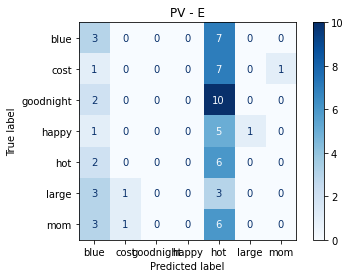

           AXL        AXL        AXL  ...       AZR       AZR       AZR
113 -0.0898438     -0.125  -0.274902  ...  0.897461  0.931152  0.858398
207  -0.570801    -0.5625  -0.558594  ...  0.799805   0.78418  0.785156
114  -0.763184  -0.830078  -0.852051  ...  0.932617  0.898438  0.861328
209  -0.539062  -0.554199  -0.598633  ...  0.751465  0.743652  0.777832
193  -0.097168 -0.0961914 -0.0776367  ...  0.964355  0.990723  0.970703
..         ...        ...        ...  ...       ...       ...       ...
49   -0.491699  -0.498535  -0.521484  ...  0.641113  0.635254     0.625
91  -0.0288086  0.0327148    0.17041  ...  0.756836  0.745117  0.769531
25           0          0          0  ...  0.967285  0.842773  0.670898
56  -0.0629883 -0.0424805 -0.0292969  ...  0.798828  0.811523  0.791016
121  -0.583984  -0.579102  -0.583496  ...  0.740723   0.78125   0.78418

[147 rows x 300 columns]
[[-8.93585593e-01 -2.46546421e-01 -2.64988782e-01 ...  1.15107657e-03
  -1.90534271e-03  6.66133815e-16]
 [-3.

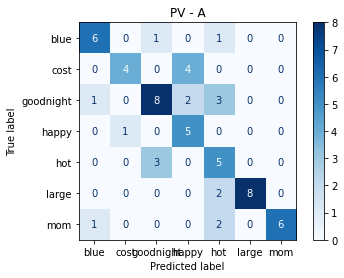

         GXL     GXL     GXL     GXL  ...      GZR      GZR      GZR      GZR
196  -1.8125 -2.1875      -3 -2.8125  ...       -1       -1   2.3125    -2.75
201  -1.0625  1.1875  -1.125 -0.3125  ... -42.0625 -35.9375 -22.4375    -4.75
193  -6.9375 -1.8125 -3.9375  0.3125  ...   -6.125  -0.9375      8.5      9.5
14   -4.3125 -3.8125 -1.0625  -1.625  ...   -16.25   6.3125  18.6875   28.875
41    16.625    16.5    1.75 -0.3125  ...   -0.875  -0.8125    -0.75   -0.875
..       ...     ...     ...     ...  ...      ...      ...      ...      ...
182  -2.1875 -1.3125 -0.1875  8.8125  ...     -7.5    -7.25 -11.4375  -13.125
2     -0.375      -1      -1 -1.0625  ...  112.062  34.0625   -1.125    3.375
57  -11.4375  8.1875  2.1875  -1.375  ...   -0.375  -0.6875        0    0.125
192   2.8125 -0.4375 -4.1875    -1.5  ...   0.5625        3  -0.0625    1.375
105    -0.75    -0.5     -31  1.4375  ...       11    2.125    9.875  11.3125

[147 rows x 300 columns]
[[-5.16421859e+16 -5.40796235e+09 -9.4

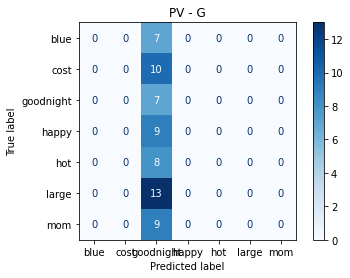

    ORL ORL ORL ORL ORL ORL ORL ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR  OYR
19   65  65  65  65  65  65  65  65  ...   52   52   52   52   52   52   52   52
153  85  85  84  84  84  86  88  91  ...  142  141  140  140  140  139  139  139
207  72  72  71  71  72  72  72  72  ...  175  175  175  175  176  176  176  175
171  69  70  75  79  82  85  87  88  ...  116  117  119  121  124  128  130  134
29   67  67  67  67  67  67  67  67  ...   63   64   66   69   71   73   75   76
..   ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...
139  64  64  64  64  64  64  64  64  ...  154  155  156  156  156  156  155  154
203  78  78  78  78  78  78  78  78  ...   87   87   87   87   87   87   86   86
45   55  54  54  54  54  54  54  54  ...  151  147  145  144  142  141  140  140
202  63  63  62  62  62  62  62  62  ...  155  154  151  150  149  147  146  146
111  69  69  69  69  68  67  67  65  ...   93   93   94   96   99  102  109  112

[147 rows x 300 columns]
[[

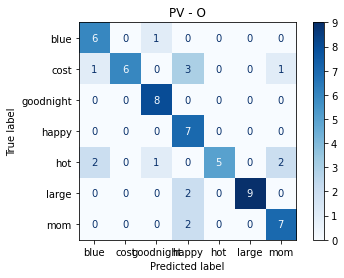

    EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR
163     0         0   1.19329  ...  0.802734  0.789062  0.790039
4       0  -1.19329  0.632951  ...  0.792969  0.755859  0.722168
116     0         0         0  ...   1.01807   1.03271   1.04199
34      0         0   2.98322  ...  0.946289   0.95166   0.95752
182     0         0  -2.38658  ...   0.63916  0.623047  0.648438
..    ...       ...       ...  ...       ...       ...       ...
179     0         0  -3.57986  ...  0.961914  0.765137   0.81543
23      0 -0.596644  0.614797  ...  0.799316  0.918457   1.01855
21      0         0  -1.19329  ...  0.977051  0.405762      1.75
3       0         0  -1.19329  ...  0.851562  0.858398  0.879395
121     0         0  -1.19329  ...  0.740723   0.78125   0.78418

[147 rows x 1100 columns]
[[ 1.24413391e+00  1.07367171e+01  2.94700408e+01 ... -4.78507168e-01
  -5.39681614e-01 -7.04991621e-15]
 [-1.49111539e+01 -1.11010691e+02  5.50039315e+01 ... -2.81832723e-03
  -7.79042370e-01 

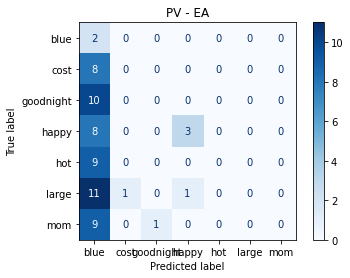

    EMG0L EMG0L    EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
134     0     0  11.9329   -11.1027  ...    0.375    0.125   0.3125      0.5
152     0     0  2.38658    1.71732  ...    4.875    7.375      7.5        5
64      0     0 -5.96644   -3.39833  ...  -2.6875   1.1875    1.125  -0.4375
55      0     0  1.19329    12.4932  ...       -3  -2.5625  -2.8125  -2.1875
184     0     0 -1.19329   0.632951  ...   -1.625     0.25     0.75   -0.125
..    ...   ...      ...        ...  ...      ...      ...      ...      ...
164     0     0  4.17651   -1.91701  ...   60.375  63.8125  45.5625       43
8       0     0        0          0  ...  110.438  85.9375  48.8125  13.1875
39      0     0  2.98322 -0.0907663  ...    2.125   1.3125     0.25    0.625
118     0     0  1.19329   -1.22959  ...  -5.8125   -1.625     -2.5    -2.25
209     0     0 -1.19329   -1.15698  ...  -2.9375  -2.9375   -5.125      0.5

[147 rows x 1100 columns]
[[-5.37117350e+09  2.19618234e+01 -1.00433830e+01

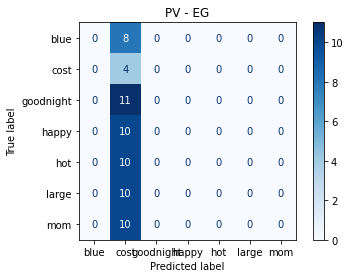

    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
51      0     0 -0.596644   -7.73822   6.51428  ...   26   25   25   26   26
205     0     0 -0.596644    1.21144   2.66212  ...   88   88   87   87   87
75      0     0 -0.596644  0.0181533 -0.881439  ...   91   91   91   91   91
200     0     0 -0.596644  0.0181533 -0.284795  ...  150  149  148  147  146
72      0     0         0          0 -0.596644  ...   84   84   84   84   84
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
118     0     0   1.19329   -1.22959  -2.37732  ...  172  172  172  172  172
89      0     0  -2.38658   -2.91061   3.72474  ...   83   83   83   83   83
134     0     0   11.9329   -11.1027  -23.8096  ...   69   69   69   69   69
90      0     0  -3.57986    -11.824   9.39389  ...  129  128  128  127  127
187     0     0 -0.596644  0.0181533  0.908494  ...   28   28   28   28   28

[147 rows x 1100 columns]
[[ 4.10514498e+02  2.26654941e+02  1.40510016e+02

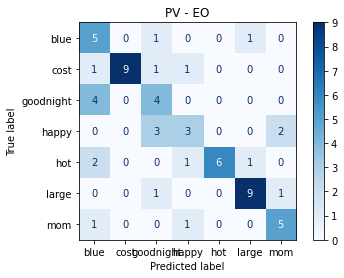

           AXL         AXL        AXL  ...      GZR      GZR      GZR
128  -0.504883   -0.505859  -0.497559  ...    2.875   0.3125    0.875
69   -0.601074   -0.635742  -0.498047  ...  -4.1875    -5.75  -6.1875
155   0.334961    0.344238   0.353516  ...  157.125  154.375    93.75
14  -0.0869141  -0.0864258 -0.0766602  ...   6.3125  18.6875   28.875
4     0.353027    0.348145   0.352051  ... -21.8125 -13.6875  -5.0625
..         ...         ...        ...  ...      ...      ...      ...
138 -0.0615234  -0.0620117 -0.0712891  ... -57.9375 -61.4375 -66.8125
166  -0.215332   0.0229492  -0.090332  ...   10.125   6.0625   6.6875
159  -0.478027   -0.501465  -0.605957  ...  27.1875  18.5625   15.375
134 -0.0454102 -0.00683594  0.0175781  ...    0.125   0.3125      0.5
88   -0.679688   -0.717285    -0.6875  ...   0.6875  -1.5625   1.5625

[147 rows x 600 columns]
[[-5.16421859e+16 -5.40796236e+09  8.55456362e+01 ...  2.21352969e+02
  -3.29307049e+00  1.11041794e+00]
 [-5.16421859e+16 -5.40796235

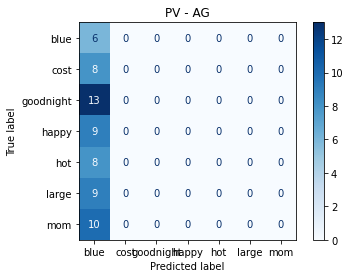

            AXL         AXL         AXL        AXL  ...  OYR  OYR  OYR  OYR
50    -0.592285   -0.689453   -0.293945   -0.12207  ...   22   22   22   22
85    -0.746094   -0.749023   -0.776367  -0.791504  ...   38   36   35   33
114   -0.763184   -0.830078   -0.852051  -0.705566  ...   33   32   31   30
146    0.724121    0.726562     0.74707   0.748047  ...  179  179  179  178
111 -0.00634766  0.00244141  -0.0366211 -0.0786133  ...   99  102  109  112
..          ...         ...         ...        ...  ...  ...  ...  ...  ...
205   -0.357422   -0.362305   -0.358887  -0.350098  ...   88   87   87   87
199  -0.0810547  -0.0727539  -0.0683594 -0.0664062  ...  146  145  145  145
133  -0.0522461  -0.0375977 -0.00488281 -0.0366211  ...   69   69   69   69
36     0.629395    0.643555     0.29248   0.109863  ...    4    4    4    4
142   -0.194824   -0.201172   -0.192871  -0.200684  ...   83   83   83   83

[147 rows x 600 columns]
[[ 4.24597763e+02 -2.64524550e+02  1.26457127e+02 ...  8.29191

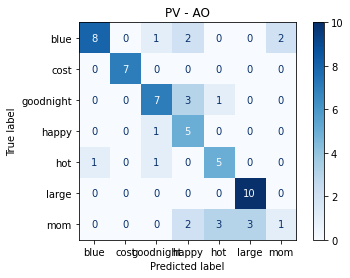

         GXL      GXL     GXL     GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
84   -0.4375  -0.4375  0.1875 -0.6875   -8.375  ...   42   42   42   42   42
3    -1.1875      0.5   4.125    0.25   2.1875  ...   45   44   44   43   43
25         0        0       0       0        0  ...   26   20   15    9    6
128     3.75   1.9375   -1.75    0.75    2.125  ...  120  120  120  120  120
90     148.5  204.312  31.125  60.375  59.4375  ...  129  128  128  127  127
..       ...      ...     ...     ...      ...  ...  ...  ...  ...  ...  ...
166 -25.5625  -68.875 -42.375    4.75   16.875  ...   54   54   54   53   53
134  -6.8125  -9.9375   -5.75      -3     -6.5  ...   69   69   69   69   69
1    -0.0625   3.6875   2.625  4.1875   7.0625  ...  113  115  116  117  117
73   13.4375   6.9375 -3.8125 -3.8125 -12.1875  ...   83   83   83   83   83
205  -0.3125   -2.125 -1.4375     6.5   -6.875  ...   88   88   87   87   87

[147 rows x 600 columns]
[[-5.37117354e+09  1.05165719e+02 -4.37474412e+02 

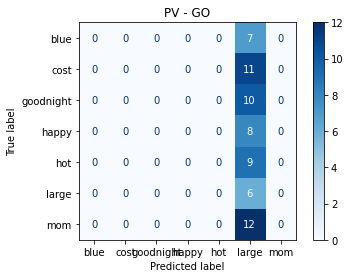

    EMG0L EMG0L     EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
24      0     0         0  -0.596644  ...   -158.5 -80.1875 -26.9375  -8.0625
164     0     0   4.17651   -1.91701  ...   60.375  63.8125  45.5625       43
140     0     0  -1.19329  0.0363065  ...     43.5  33.1875  11.9375  -0.5625
82      0     0  -4.17651      12.06  ...    -6.25   1.1875   -2.125  -1.1875
6       0     0  -1.19329  0.0363065  ...  141.938  168.938    104.5   126.25
..    ...   ...       ...        ...  ...      ...      ...      ...      ...
77      0     0  -1.19329  0.0363065  ... -89.6875  -66.125 -54.9375 -36.9375
50      0     0  -1.78993   -1.73547  ...    0.875   -1.125   -2.375  -1.4375
205     0     0 -0.596644    1.21144  ... -15.1875   3.6875   2.4375   -0.375
187     0     0 -0.596644  0.0181533  ...  -4.4375  -11.875   -5.125  -0.0625
95      0     0   5.96644   0.415112  ...   -1.125  -0.3125    3.875   2.3125

[147 rows x 1400 columns]
[[-5.16421859e+16 -5.40796236e+09  5.

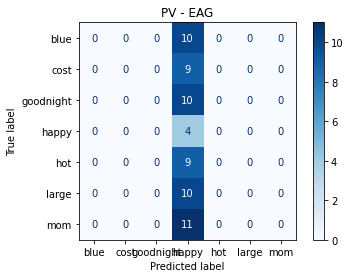

    EMG0L    EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
42      0        0         0   -1.19329  0.632951  ...   72   72   72   72   72
93      0        0   1.78993   -2.44104  -2.65287  ...  139  138  137  135  134
59      0  11.3362  -8.10129   -3.89921  -8.87333  ...   80   80   80   80   80
187     0        0 -0.596644  0.0181533  0.908494  ...   28   28   28   28   28
29      0        0  0.596644  -0.614797  -0.89034  ...   69   71   73   75   76
..    ...      ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
2       0        0  -1.78993    1.24775  0.899242  ...   39   41   44   44   44
76      0        0 -0.596644   -1.17514   1.54144  ...  170  166  164  161  159
10      0        0  -1.78993    4.23097   15.1279  ...   69   70   71   71   71
107     0        0 -0.596644   0.614797 -0.899592  ...  168  166  164  163  162
102     0        0   1.78993    19.6348  -19.4339  ...   70   70   70   70   69

[147 rows x 1400 columns]
[[ 6.00457453

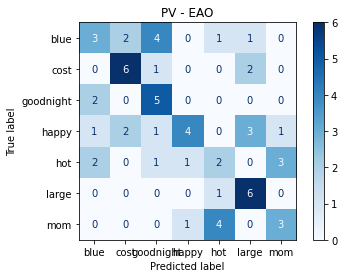

    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
35      0     0  -4.17651    6.69016    2.5799  ...    4    4    4    4    4
104     0     0  -1.19329  0.0363065  -1.16623  ...   79   78   74   71   68
105     0     0         0  -0.596644 -0.578491  ...   69   69   69   69   69
71      0     0  -5.96644    4.35804   4.78135  ...  117  117  117  117  117
52      0     0 -0.596644   -1.17514 -0.248488  ...   41   41   40   40   40
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
181     0     0 -0.596644  -0.578491  0.926647  ...  147  146  146  146  146
47      0     0  -1.19329   0.632951 -0.587743  ...  144  143  142  141  141
26      0     0   1.78993    -6.0209   6.40571  ...   77   78   78   78   78
38      0     0  0.596644   -4.79131   1.62331  ...   70   70   70   70   70
25      0     0         0          0         0  ...   26   20   15    9    6

[147 rows x 1400 columns]
[[-5.37117361e+09  5.31405162e+02  4.34316967e+02

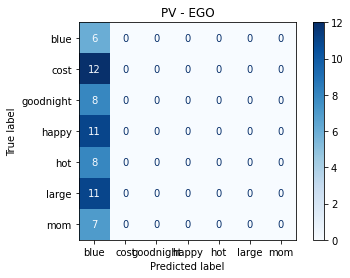

           AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
193  -0.097168 -0.0961914 -0.0776367   -0.10498  ...   20   20   20   20
143  -0.217285  -0.217285  -0.189941  -0.193848  ...   82   82   82   82
109 -0.0820312 -0.0644531 -0.0375977  0.0273438  ...  169  167  165  164
25           0          0          0          0  ...   20   15    9    6
140 -0.0595703 -0.0576172    -0.0625  -0.065918  ...  157  157  157  157
..         ...        ...        ...        ...  ...  ...  ...  ...  ...
97    0.670898   0.590332   0.597168   0.466309  ...   11   10   10    9
209  -0.539062  -0.554199  -0.598633   -0.57666  ...  176  176  176  176
182  -0.703613  -0.703613  -0.723633  -0.710938  ...  145  145  144  144
172   -0.18457  -0.270996  0.0786133   0.176758  ...   77   77   77   76
48   -0.516113  -0.505859  -0.541992  -0.433105  ...   18   18   18   19

[147 rows x 900 columns]
[[-5.16421859e+16 -5.40796236e+09  7.75643449e+01 ...  1.57577190e+02
  -2.43032053e+00 -1.0850752

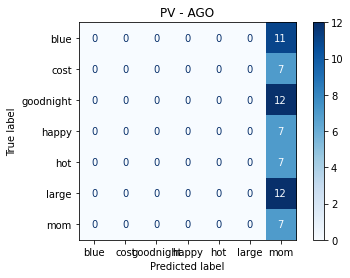

    EMG0L EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
33      0     0 -0.596644  -8.33486   7.12908  ...  122  122  122  122  122
51      0     0 -0.596644  -7.73822   6.51428  ...   26   25   25   26   26
111     0     0 -0.596644 -0.578491 -0.266641  ...   96   99  102  109  112
72      0     0         0         0 -0.596644  ...   84   84   84   84   84
87      0     0 -0.596644   1.21144   1.46883  ...   80   80   80   80   80
..    ...   ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
198     0     0   2.38658  -4.24912  -4.10355  ...   80   76   72   69   67
135     0     0 -0.596644   1.80809  -2.72583  ...   71   70   70   69   69
78      0     0         0         0  -1.78993  ...  160  158  156  154  153
144     0     0 -0.596644  0.614797 -0.302948  ...   81   81   81   81   81
193     0     0   1.19329  -8.38932   6.19353  ...   20   20   20   20   20

[147 rows x 1700 columns]
[[-5.16421859e+16 -5.40796225e+09 -5.34066262e+01 ...  1.8811

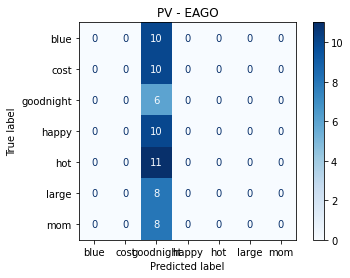

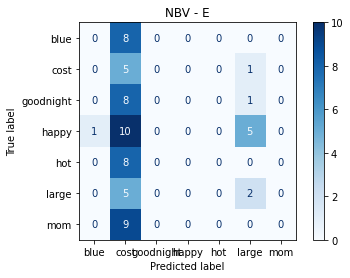

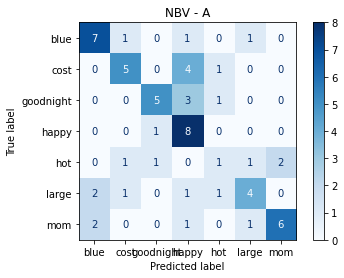

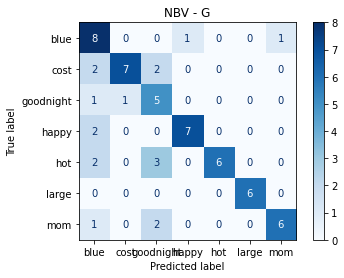

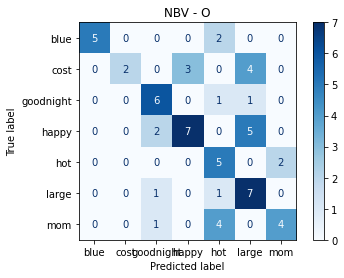

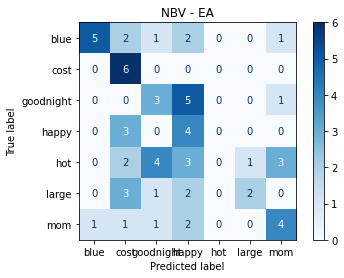

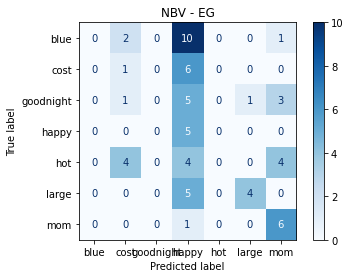

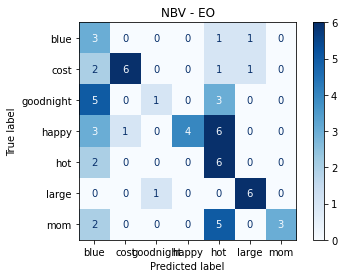

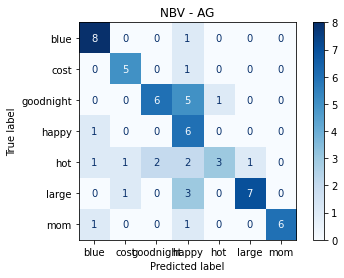

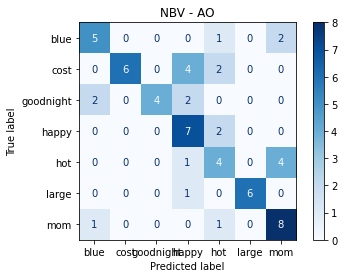

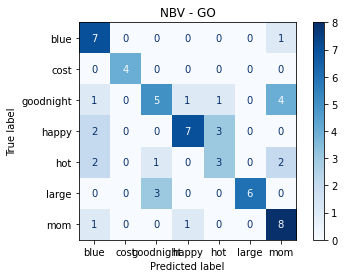

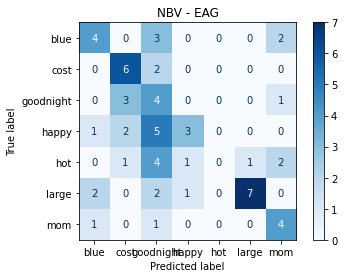

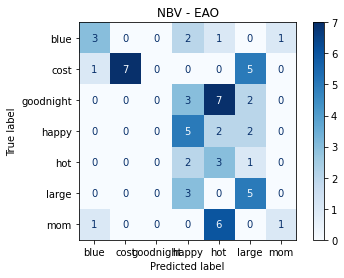

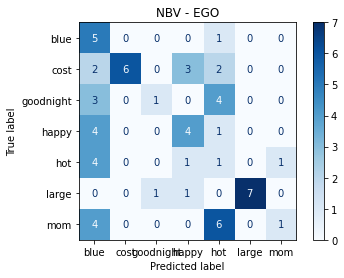

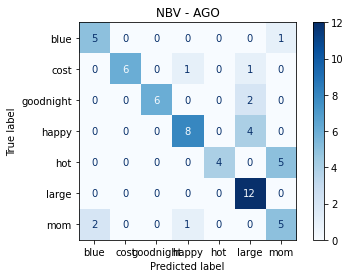

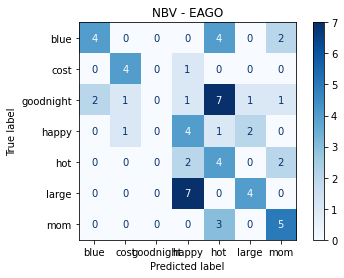

        EMG0L       EMG0L     EMG0L  ...       EMG7R       EMG7R       EMG7R
58   0.239562 -0.00728881 -0.111652  ...    0.016348  0.00226633   0.0221808
77   0.323182 -0.00983301 -0.185492  ...   0.0493212   0.0245856 -0.00907628
115  0.360683   -0.010974 -0.198632  ...   0.0830473   0.0436962   0.0178979
170  0.285063 -0.00867322 -0.119163  ...   0.0885124   -0.116146 -0.00813292
156  0.299492 -0.00911222 -0.184614  ...   -0.018089  -0.0156397   0.0043702
..        ...         ...       ...  ...         ...         ...         ...
107  0.286699 -0.00872299 -0.152433  ... -0.00320031   0.0102821   0.0182995
69   0.324905 -0.00988544 -0.169819  ...  0.00148536  -0.0108093 -0.00455106
158    0.3016 -0.00917637 -0.223203  ...   0.0226151  -0.0506531   0.0631488
203  0.270869 -0.00824136 -0.137915  ...  -0.0327382   0.0199345   0.0129751
56   0.466467  -0.0141925 -0.287202  ...  -0.0141194  0.00507731  0.00635037

[147 rows x 800 columns]
[[ 1.01786539e-01  2.16623315e-01 -1.15931269e-03 

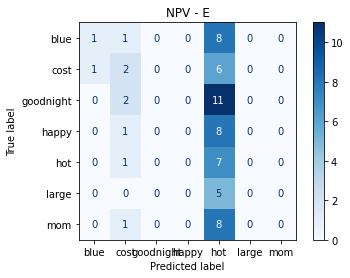

          AXL        AXL        AXL  ...       AZR       AZR       AZR
43   0.405274   0.434376   0.462696  ...   0.76797    0.7709  0.768556
208  0.087747  0.0832017  0.0863636  ...  0.644466  0.632213  0.629051
150   0.18531   0.188474   0.192542  ...  0.755254  0.804745  0.808587
101  0.158937   0.177651   0.217521  ...  0.839709  0.839166   0.84215
78   0.435805   0.439644   0.504439  ...  0.951761  0.955364  0.958244
..        ...        ...        ...  ...       ...       ...       ...
56   0.343861   0.352646   0.358293  ...  0.713031  0.718469  0.709684
149  0.093274   0.100465  0.0856599  ...  0.679991  0.647207  0.662224
187  0.535476   0.526258   0.520042  ...  0.860021  0.877384  0.859806
171  0.574999   0.592289   0.624765  ...  0.833176  0.841587  0.882708
95   0.781616   0.757788   0.555903  ...   0.78921  0.780307  0.780831

[147 rows x 300 columns]
[[-2.87269772e-01 -3.23966529e-01 -3.54043951e-01 ... -9.14622258e-04
   1.78788111e-03  5.27355937e-16]
 [-2.48221037e+00

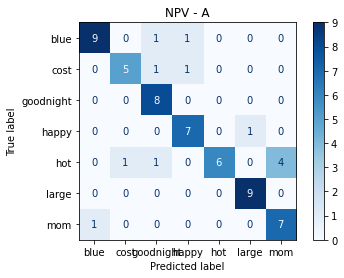

          GXL       GXL       GXL  ...       GZR       GZR       GZR
52   0.314212  0.287442  0.201581  ...  0.409203  0.411424  0.412164
91   0.637643  0.621525  0.703067  ...  0.430943  0.433472   0.42557
89   0.645998  0.655011  0.617093  ...  0.572183  0.585858  0.579486
189  0.497969  0.500211  0.505815  ...  0.497969   0.49951  0.500211
75   0.545334  0.545334  0.517219  ...  0.439695  0.439528  0.437366
..        ...       ...       ...  ...       ...       ...       ...
164  0.560792  0.506972  0.412716  ...  0.858617  0.777189  0.765756
85   0.612125  0.603619  0.565574  ...  0.550108  0.543149  0.543613
152  0.490418   0.51135  0.456165  ...  0.464592  0.464864  0.459427
64   0.378685  0.398848  0.117587  ...  0.455608  0.455439  0.451203
5    0.405031  0.402263  0.431194  ...  0.380125  0.436226   0.22415

[147 rows x 300 columns]
[[ 9.80805879e-01 -6.32149567e-01  1.45506576e-01 ...  1.09733553e-02
  -3.77448542e-03  6.62664368e-16]
 [ 6.24953627e-02  1.42326843e+00  5.1801

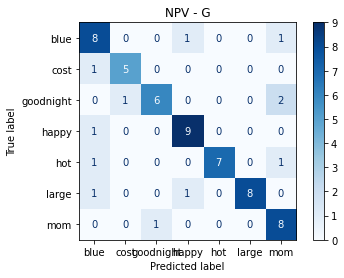

          ORL       ORL       ORL  ...        OYR        OYR        OYR
156   0.47486  0.480447  0.480447  ...  0.0391061  0.0446927  0.0502793
204  0.464286  0.464286  0.464286  ...   0.547619   0.547619   0.547619
7    0.328767  0.328767  0.328767  ...    0.30137    0.30137    0.30137
128  0.338583  0.338583  0.338583  ...   0.685039   0.685039   0.685039
103  0.681818   0.69697  0.666667  ...   0.378788   0.378788   0.378788
..        ...       ...       ...  ...        ...        ...        ...
99    0.52381   0.52381  0.547619  ...       0.75       0.75       0.75
180  0.511236  0.511236  0.511236  ...   0.803371   0.797753   0.797753
129  0.346457  0.346457  0.346457  ...   0.708661   0.708661   0.708661
175  0.564246  0.558659  0.530726  ...    0.96648    0.96648   0.960894
177  0.413408  0.424581  0.435754  ...    0.96648    0.96648   0.972067

[147 rows x 300 columns]
[[-1.00453435e+00 -8.57300024e-01  8.47793690e-01 ...  1.95979098e-04
  -1.91360244e-04  8.67795419e-16]
 [ 9.

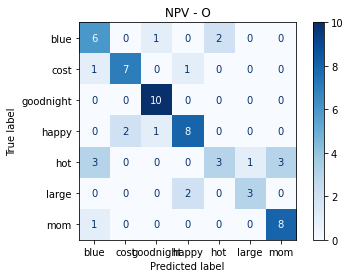

        EMG0L       EMG0L     EMG0L  ...       AZR       AZR       AZR
124  0.252426 -0.00768022  -0.14341  ...  0.708744  0.695426  0.702954
75   0.237878 -0.00723757 -0.128232  ...  0.870656  0.873574  0.874453
170  0.285063 -0.00867322 -0.119163  ...  0.888503  0.953973  0.971046
178  0.314263 -0.00956164 -0.114157  ...  0.832335  0.824118  0.838997
166  0.279381 -0.00850033 -0.131819  ...  0.923621  0.951355  0.902252
..        ...         ...       ...  ...       ...       ...       ...
207  0.225757  -0.0068688 -0.117997  ...  0.814901  0.806652  0.807167
139  0.317364 -0.00965599  -0.17434  ...  0.948777  0.956657  0.979509
184  0.360238  -0.0109605 -0.193915  ...  0.860314  0.851875  0.856539
40   0.429403  -0.0130648 -0.283197  ...  0.754169  0.753502  0.751501
94   0.295954 -0.00900459 -0.164158  ...  0.746128  0.761155  0.747722

[147 rows x 1100 columns]
[[ 9.71453957e-01  1.23862562e+00  6.59269256e-01 ... -1.44988018e-02
   2.14885706e-02  9.43689571e-16]
 [-1.42721847e+0

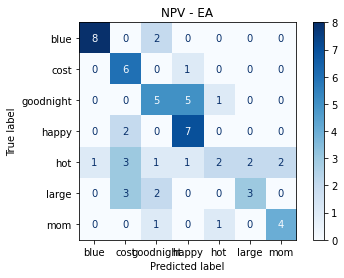

        EMG0L       EMG0L      EMG0L  ...       GZR       GZR       GZR
156  0.299492 -0.00911222  -0.184614  ...  0.610809  0.565397  0.546358
86   0.293802  -0.0089391 -0.0993218  ...  0.474593  0.473897  0.475011
137  0.272579 -0.00829337  -0.145498  ...  0.410221  0.374779  0.379674
59   0.335612    0.107875  -0.259804  ...   0.49385  0.499858   0.48126
21    0.33544   -0.010206  -0.180824  ...  0.376319  0.325468  0.596746
..        ...         ...        ...  ...       ...       ...       ...
11   0.298322 -0.00907663  -0.226118  ...  0.594118  0.524808  0.480307
206  0.272884 -0.00830265  -0.147254  ...  0.582398  0.580692  0.582398
132  0.258123 -0.00785354  -0.109524  ...  0.426217  0.426903  0.427246
140  0.358766  -0.0109157  -0.195317  ...   0.56325   0.49399  0.453248
179  0.177573 -0.00540275  -0.114121  ...  0.590271  0.569228   0.49756

[147 rows x 1100 columns]
[[-4.49897455e-01  1.93619434e+00  3.35275450e-01 ... -2.54387179e-02
   1.73222743e-02  8.46545056e-16]
 [-9

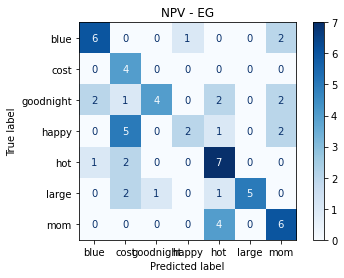

        EMG0L       EMG0L     EMG0L  ...        OYR        OYR        OYR
166  0.279381 -0.00850033 -0.131819  ...   0.246154   0.230769   0.230769
22    0.31558 -0.00960172 -0.169876  ...   0.102564  0.0897436  0.0897436
75   0.237878 -0.00723757 -0.128232  ...   0.647059   0.647059   0.647059
58   0.239562 -0.00728881 -0.111652  ...   0.396552   0.396552   0.396552
205  0.316103 -0.00961762  -0.16917  ...    0.55914    0.55914    0.55914
..        ...         ...       ...  ...        ...        ...        ...
24   0.253122 -0.00770138   -0.1323  ...  0.0364964  0.0145985          0
151  0.346886  -0.0105542 -0.148932  ...   0.770492   0.770492   0.770492
176  0.253122 -0.00770138  -0.15038  ...   0.960894   0.955307   0.955307
19   0.299492 -0.00911222 -0.165895  ...  0.0609756  0.0609756  0.0609756
68   0.188682 -0.00574077 -0.119017  ...   0.494382   0.494382   0.494382

[147 rows x 1100 columns]
[[-1.28754994e+00  2.32034793e+00  9.15234361e-01 ... -3.81577746e-02
  -1.90011024e-

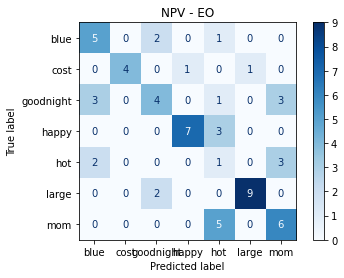

          AXL        AXL        AXL  ...       GZR       GZR       GZR
47   0.414007   0.474306   0.545172  ...  0.272085  0.342474  0.425726
85   0.032856  0.0314482  0.0183056  ...  0.550108  0.543149  0.543613
20   0.251004   0.251216    0.25629  ...  0.516911  0.403619  0.346973
19   0.526654   0.526525   0.523564  ...  0.612643  0.612298  0.612068
1   0.0356591  0.0434108  0.0436696  ...  0.588915  0.518448  0.481204
..        ...        ...        ...  ...       ...       ...       ...
50   0.286513   0.245287   0.413093  ...  0.422301  0.418987  0.421472
94   0.162113   0.114526    0.11316  ...  0.453583  0.454735  0.460033
12   0.194705   0.193413   0.194382  ...  0.492102  0.493231  0.492102
2     0.57055   0.570257   0.566745  ...  0.564513   0.42615  0.443845
53    0.20917   0.204555   0.185797  ...  0.445928  0.444965  0.448574

[147 rows x 600 columns]
[[ 1.47059244e-01 -2.23169462e-01  1.98083418e+00 ... -1.13070934e-02
   6.56577305e-03  9.74914593e-16]
 [-1.42005847e+00

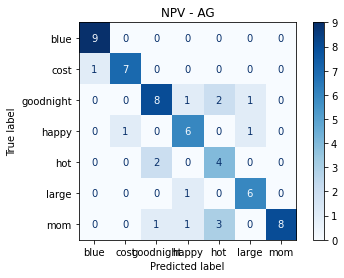

           AXL        AXL        AXL  ...        OYR        OYR         OYR
73    0.213235   0.212596   0.262468  ...   0.571429   0.571429    0.571429
29   0.0159101  0.0262052  0.0535801  ...   0.234568   0.259259    0.271605
185   0.670096   0.678046   0.674772  ...  0.0148148  0.0148148  0.00740741
196   0.195664   0.199187   0.194039  ...   0.347222   0.347222    0.347222
105   0.291146   0.292187   0.241146  ...        0.5        0.5         0.5
..         ...        ...        ...  ...        ...        ...         ...
129   0.164395   0.159984   0.168605  ...   0.708661   0.708661    0.708661
35    0.261371   0.285585   0.333333  ...  0.0162602  0.0162602   0.0162602
43    0.405274   0.434376   0.462696  ...   0.384615   0.384615    0.384615
186   0.498571   0.493959   0.483636  ...      0.024      0.024       0.024
91    0.308269   0.340827   0.413695  ...   0.745098   0.745098    0.735294

[147 rows x 600 columns]
[[-1.52478197e+00 -1.66291914e+00  1.11203970e+00 ... -1.11381

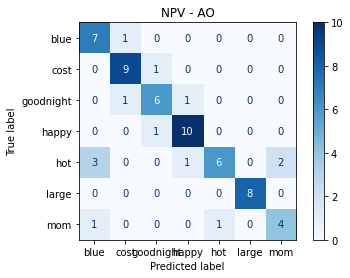

          GXL        GXL       GXL  ...        OYR        OYR         OYR
193  0.435654   0.452246  0.445366  ...    0.19802    0.19802     0.19802
201   0.47065   0.478171  0.470442  ...   0.810056   0.810056    0.810056
132  0.422442    0.43411  0.412833  ...   0.380952   0.380952    0.380952
89   0.645998   0.655011  0.617093  ...   0.432099   0.432099    0.432099
202  0.401324   0.399955  0.401096  ...   0.821229   0.815642    0.815642
..        ...        ...       ...  ...        ...        ...         ...
44   0.128256  0.0776413  0.266339  ...   0.747826   0.747826    0.747826
158  0.677886   0.740612  0.709318  ...   0.794643   0.794643    0.803571
97   0.227155   0.219702  0.258911  ...  0.0178571  0.0178571  0.00892857
69   0.485069   0.426797  0.594996  ...   0.521277   0.521277    0.510638
208  0.481046   0.494536  0.485228  ...    0.98324    0.98324     0.98324

[147 rows x 600 columns]
[[-2.18300646e+00  5.07008777e+00 -7.46879718e-01 ... -2.10129836e-02
   2.85150898e-0

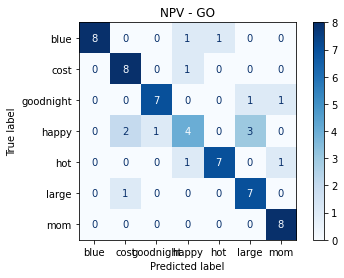

        EMG0L       EMG0L      EMG0L  ...        GZR        GZR        GZR
33   0.318401 -0.00968755  -0.169288  ...   0.538554   0.537915   0.538474
90   0.359174  -0.0109281  -0.205541  ...   0.420369   0.422054   0.421573
76   0.204564 -0.00622397  -0.112602  ...  0.0289459  0.0686705  0.0635641
150  0.298322 -0.00907663     -0.211  ...   0.428788   0.398985   0.390741
196  0.307743 -0.00936326 -0.0854831  ...   0.496999   0.505599   0.492456
..        ...         ...        ...  ...        ...        ...        ...
169  0.351664  -0.0106996  -0.179854  ...   0.926171   0.888592   0.871891
36   0.344011  -0.0104667  -0.308809  ...   0.388048   0.388048   0.387519
160  0.338481  -0.0102985  -0.205599  ...   0.535652   0.492013   0.479177
167  0.336434  -0.0102362  -0.186358  ...   0.630794   0.670721   0.709959
60   0.351753  -0.0107023  -0.188304  ...   0.432681   0.432546   0.432951

[147 rows x 1400 columns]
[[-1.32562445e-02  3.99253673e-01 -1.47638099e+00 ...  2.20230479e-02
   

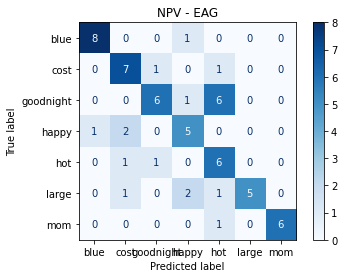

        EMG0L       EMG0L     EMG0L  ...        OYR        OYR        OYR
127  0.332308  -0.0101107 -0.188793  ...      0.704      0.696      0.696
8    0.269319 -0.00819418 -0.140765  ...   0.311688   0.337662   0.363636
26   0.348405  -0.0106004 -0.169037  ...   0.301205   0.301205   0.301205
91   0.275569 -0.00838434 -0.171842  ...   0.745098   0.745098   0.735294
69   0.324905 -0.00988544 -0.169819  ...   0.521277   0.521277   0.510638
..        ...         ...       ...  ...        ...        ...        ...
190  0.361603   -0.011002 -0.176946  ...   0.747967   0.747967   0.747967
115  0.360683   -0.010974 -0.198632  ...   0.142857   0.133929      0.125
82   0.308266 -0.00937918 -0.178524  ...  0.0816327  0.0816327  0.0816327
205  0.316103 -0.00961762  -0.16917  ...    0.55914    0.55914    0.55914
133  0.371047  -0.0112893 -0.187999  ...   0.372093   0.372093   0.372093

[147 rows x 1400 columns]
[[ 1.95501772e+00 -3.52680876e+00 -1.04367475e+00 ... -8.75689338e-03
   7.14124291e-

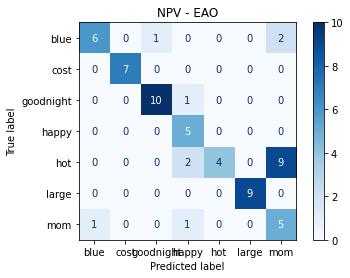

        EMG0L       EMG0L     EMG0L  ...        OYR        OYR         OYR
48   0.337104  -0.0102566 -0.188128  ...          0          0  0.00892857
67   0.318454 -0.00968916 -0.177428  ...   0.461538   0.461538    0.461538
83   0.287363  -0.0087432 -0.147762  ...  0.0952381  0.0952381   0.0952381
105  0.337234  -0.0102605 -0.176263  ...        0.5        0.5         0.5
91   0.275569 -0.00838434 -0.171842  ...   0.745098   0.745098    0.735294
..        ...         ...       ...  ...        ...        ...         ...
54   0.327362 -0.00996019 -0.155263  ...       0.01       0.01           0
94   0.295954 -0.00900459 -0.164158  ...  0.0512821  0.0512821   0.0512821
57   0.228945 -0.00696578 -0.119663  ...      0.775      0.775       0.775
119  0.312757 -0.00951582 -0.149034  ...   0.985075   0.985075    0.985075
141  0.372374  -0.0113297 -0.198861  ...   0.426667   0.426667    0.426667

[147 rows x 1400 columns]
[[ 3.32161878e+00  2.30160662e+00  7.46144780e-01 ...  9.66105469e-02
  -

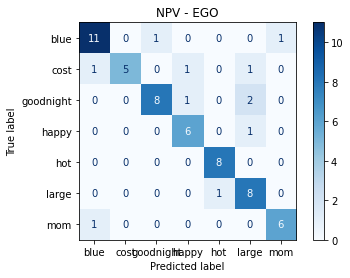

           AXL        AXL        AXL  ...       OYR       OYR         OYR
148  0.0879352  0.0918796  0.0916473  ...  0.966292  0.966292    0.966292
181  0.0995527  0.0993174   0.111555  ...  0.815642  0.815642    0.815642
48    0.220476   0.223744    0.21223  ...         0         0  0.00892857
54    0.159684   0.158246   0.201763  ...      0.01      0.01           0
2      0.57055   0.570257   0.566745  ...  0.153061  0.153061    0.153061
..         ...        ...        ...  ...       ...       ...         ...
203    0.31829    0.31829   0.315516  ...  0.568182  0.556818    0.556818
198   0.187867   0.184232   0.190942  ...  0.589041  0.547945    0.520548
73    0.213235   0.212596   0.262468  ...  0.571429  0.571429    0.571429
105   0.291146   0.292187   0.241146  ...       0.5       0.5         0.5
33    0.381237   0.380273   0.404546  ...  0.666667  0.666667    0.666667

[147 rows x 900 columns]
[[-1.89760417e+00  2.30427256e+00  4.72849693e-01 ... -1.24790789e-02
   5.62597764e-0

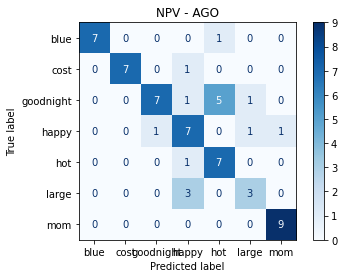

        EMG0L       EMG0L     EMG0L  ...       OYR       OYR       OYR
42   0.233064 -0.00709112 -0.121816  ...  0.482759  0.482759  0.482759
55   0.371022  -0.0112886 -0.183896  ...         0         0         0
197   0.34753  -0.0105738 -0.178569  ...  0.309859  0.295775   0.28169
141  0.372374  -0.0113297 -0.198861  ...  0.426667  0.426667  0.426667
204   0.25034 -0.00761675 -0.130846  ...  0.547619  0.547619  0.547619
..        ...         ...       ...  ...       ...       ...       ...
124  0.252426 -0.00768022  -0.14341  ...  0.037594  0.037594  0.037594
171  0.320884  -0.0097631 -0.172731  ...     0.675  0.691667     0.725
187  0.393243  -0.0119646 -0.208927  ...  0.030303  0.030303  0.030303
15   0.274456  -0.0083505 -0.203115  ...  0.464286  0.464286  0.464286
75   0.237878 -0.00723757 -0.128232  ...  0.647059  0.647059  0.647059

[147 rows x 1700 columns]
[[-1.74110654e+00 -1.53349367e+00 -1.60243879e+00 ...  4.05357201e-02
  -3.03700792e-02  1.48492330e-15]
 [-2.98808872e+0

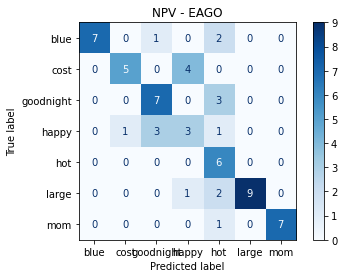

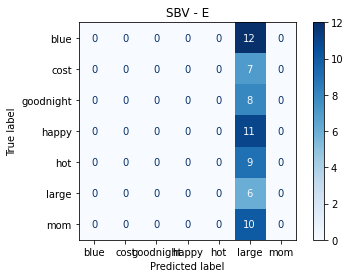

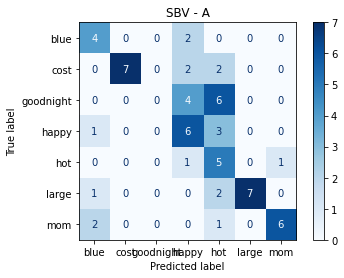

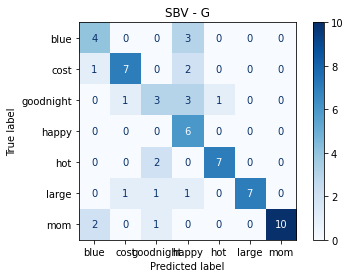

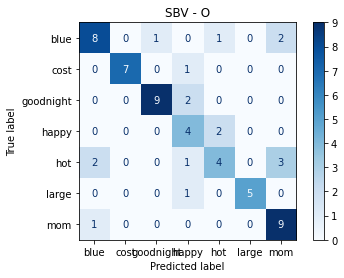

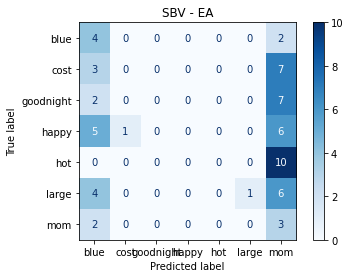

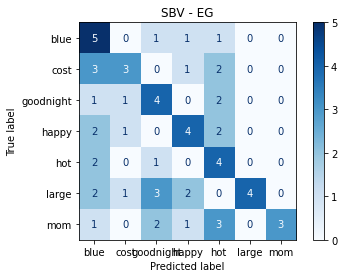

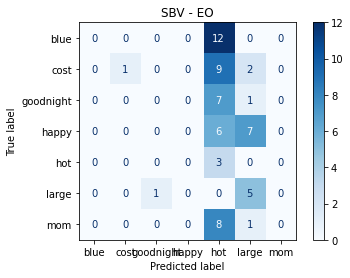

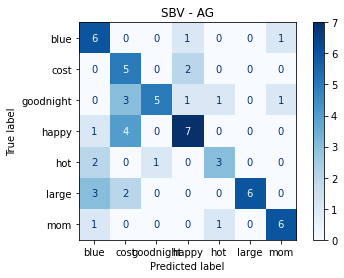

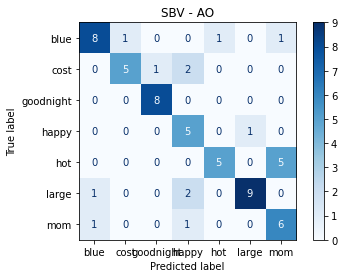

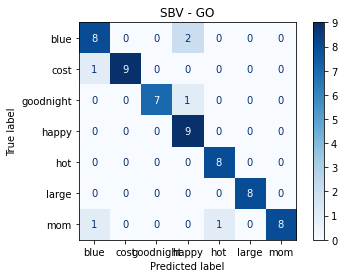

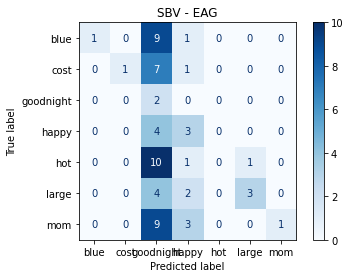

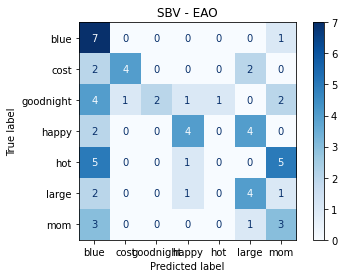

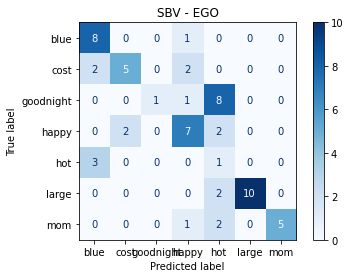

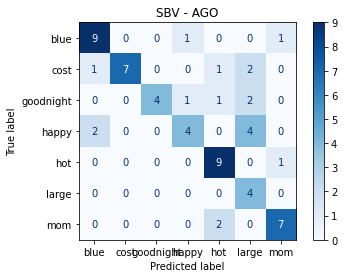

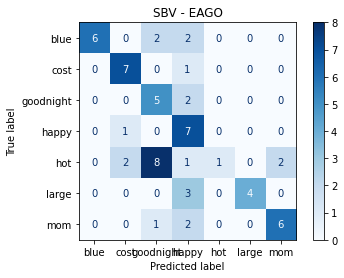

           EMG0L        EMG0L      EMG0L  ...      EMG7R      EMG7R      EMG7R
131    0.0736083  -0.00223958    0.41757  ... -0.0817041   -0.89783   0.882668
75     0.0894808  -0.00272251    -0.1079  ...   0.203806  -0.136927    1.08871
72     0.0873048   -0.0026563 -0.0456318  ...  -0.676859   0.541304   0.357224
173    0.0647247  -0.00196929   0.623274  ... -0.0528932  -0.251026   0.306634
90     0.0480378  -0.00146158  -0.279052  ...  -0.412888   0.159814  -0.164616
..           ...          ...        ...  ...        ...        ...        ...
106    0.0672849  -0.00204718  -0.035168  ...   0.323565    0.33895    0.50112
115  0.000652685 -1.98583e-05  -0.120837  ...   0.989541   0.520656    0.21326
65      0.090446  -0.00275187    1.77192  ...    0.10455  0.0563759  0.0199884
46     0.0458904  -0.00139624 -0.0239856  ...   0.160192  -0.213183   0.139721
138     0.044028  -0.00133958 -0.0718643  ...  -0.244325   0.115421 -0.0791574

[147 rows x 800 columns]
[[-8.85221088e+00 -1.70319

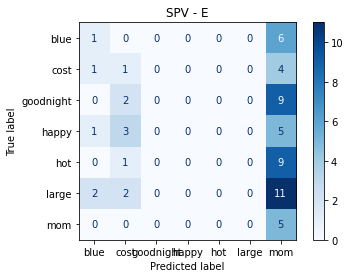

          AXL         AXL       AXL  ...       AZR       AZR       AZR
75  -0.536493   -0.536493 -0.562856  ...   1.38331   1.39272   1.39555
140 -0.417929   -0.414447 -0.423152  ...   1.28569   1.29092   1.38145
61   -1.96832    -1.94968  -1.55641  ...   1.01014   1.01666   1.01852
78  -0.462108   -0.447946 -0.208964  ...   1.44089   1.45417    1.4648
188 -0.821232    -0.81957   -0.8204  ...   1.26899   1.26235   1.27149
..        ...         ...       ...  ...       ...       ...       ...
116  -1.37356    -1.40543  -1.48208  ...   1.46942   1.49525   1.51161
48  -0.998804   -0.981749  -1.04185  ...  0.944583  0.917782  0.898292
46  -0.494194    -0.47621 -0.553283  ...    1.4335   1.54655   1.56795
45   0.160267 -0.00939398 -0.147188  ...   1.44348   1.51409   1.64243
174  -1.05555   -0.994981 -0.977001  ...   1.54793   1.44761    1.6388

[147 rows x 300 columns]
[[ 1.32242781e+00 -1.87981182e-01  3.54630116e+00 ...  4.75950636e-02
  -4.38646181e-03  1.30451205e-15]
 [-4.86238716e+00

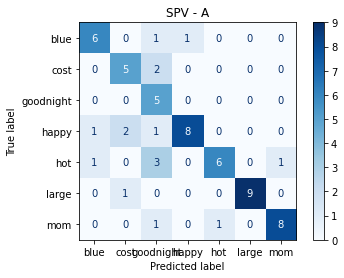

           GXL        GXL        GXL  ...         GZR         GZR         GZR
76    -0.06091 -0.0571029 -0.0621791  ...    -2.56853    -2.30205    -2.33631
13   0.0494437 -0.0384169   -0.11791  ...  0.00760529  0.00202684  0.00621068
145 -0.0243844 -0.0146709 -0.0923789  ...   -0.206782   -0.171166  -0.0276222
85  -0.0271449 -0.0869192  -0.354274  ...   -0.462954   -0.511861     -0.5086
41    0.333174   0.330027 -0.0412318  ...    -0.10573   -0.104157   -0.107303
..         ...        ...        ...  ...         ...         ...         ...
173   0.497387   0.629192   0.593081  ...   -0.550735   -0.259138   -0.270875
64    -0.60044  -0.452223   -2.51978  ...  -0.0349741  -0.0362196  -0.0673576
116  -0.629111    -1.0384   -1.32244  ...   -0.428055    -0.51103   -0.456777
71    -2.04456   -2.06808   0.387397  ...    0.037174   0.0580828   0.0620032
204 -0.0278144 -0.0985009   0.098096  ...  0.00752888   0.0450811   0.0152602

[147 rows x 300 columns]
[[ 3.56178238e-01 -5.58989527e+00 -7.8

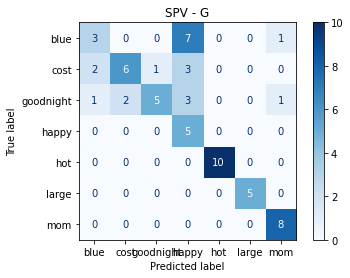

          ORL       ORL       ORL  ...       OYR       OYR       OYR
118 -0.445888 -0.418477 -0.418477  ...   1.96629   1.96629   1.96629
40  -0.978445 -0.939771 -0.862424  ...  -0.82375  -0.82375  -0.82375
62   0.750431  0.750431  0.648517  ...  -1.74648  -1.74648  -1.74648
165  0.206915  0.131122  0.131122  ...  -1.30895  -1.23315  -1.23315
97   0.344233  0.344233  0.249837  ...  -2.07862  -2.07862  -2.11008
..        ...       ...       ...  ...       ...       ...       ...
108 -0.915045 -0.915045 -0.915045  ...   1.97546   1.91933    1.8632
32  -0.635368 -0.635368 -0.810199  ...   1.24407   1.24407   1.24407
164  0.613275  0.613275  0.470708  ...  -1.31138  -1.24009  -1.24009
37  -0.904322 -0.941924 -0.979526  ...  -1.01713  -1.01713  -1.01713
196  0.128863  0.128863  0.128863  ... -0.991688 -0.991688 -0.991688

[147 rows x 300 columns]
[[-1.41798962e+01  3.74977160e+00  3.13987795e+00 ... -2.21676820e-03
  -6.49869013e-03  2.88657986e-15]
 [ 4.69709662e+00 -1.25547527e+01 -2.6316

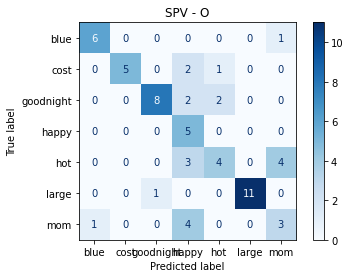

         EMG0L        EMG0L      EMG0L  ...       AZR       AZR       AZR
206  0.0471917  -0.00143584 -0.0888722  ...   1.05242   1.00525   1.02583
195  0.0654363  -0.00199094 -0.0342017  ...   1.78245    1.1312   1.24796
165  0.0272842 -0.000830139  -0.260898  ...   1.29334   1.41546   1.39912
41   0.0619942  -0.00188621  -0.394036  ...   1.41954   1.41599   1.40445
208    0.05597  -0.00170292 -0.0970963  ...   1.12315   1.07071   1.05718
..         ...          ...        ...  ...       ...       ...       ...
55    0.065822  -0.00200267  0.0675475  ...  0.958164   1.01515   1.03306
70  -0.0206473  0.000628205    0.11244  ...  0.500077  0.506082  0.486062
61   0.0826598  -0.00251497  -0.186338  ...   1.01014   1.01666   1.01852
2    0.0284299 -0.000864996  -0.120155  ...   1.43667   1.33305     1.198
51    0.020404 -0.000620804 -0.0602792  ...    1.0147  0.936776  0.941696

[147 rows x 1100 columns]
[[-5.86228641e+00 -5.63638847e+00  1.52838855e+00 ...  2.13807359e+00
  -1.10802483e-

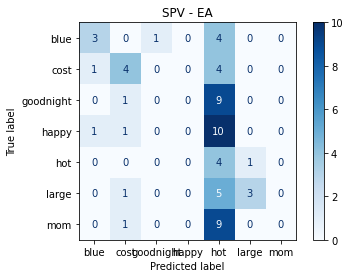

         EMG0L       EMG0L      EMG0L  ...        GZR         GZR        GZR
11   0.0527826 -0.00160594   -0.81441  ...   0.552329    0.136425  -0.130614
177  0.0392444 -0.00119403   0.557965  ...  -0.392562 -0.00381583 -0.0904425
50   0.0853223 -0.00259598  -0.177393  ... -0.0665317  -0.0887164 -0.0720779
68   0.0739117 -0.00224881  -0.428925  ...  -0.059053   -0.078568 -0.0663711
123  0.0556481 -0.00169313  0.0169996  ...  -0.215984   -0.107113  0.0102412
..         ...         ...        ...  ...        ...         ...        ...
138   0.044028 -0.00133958 -0.0718643  ...   -1.29781    -1.37522    -1.4941
75   0.0894808 -0.00272251    -0.1079  ... -0.0585812  -0.0599831 -0.0782079
41   0.0619942 -0.00188621  -0.394036  ...   -0.10573   -0.104157  -0.107303
87   0.0629643 -0.00191573  -0.114154  ... -0.0980477   -0.177031  -0.153054
139  0.0856744 -0.00260669  -0.170771  ...  -0.347785    -1.08366   -1.38703

[147 rows x 1100 columns]
[[ 2.94872520e+00 -4.54690602e-01 -1.53846761e+00

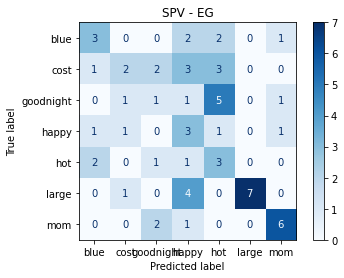

          EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
154 -0.00993134  0.000302167  -0.192202  ...   1.57482   1.72882   1.93415
79    0.0847651  -0.00257903  -0.129389  ...   1.91111   1.85548   1.79985
150     0.09937  -0.00302339  -0.739223  ...   1.45805   1.42754   1.42754
118   0.0201093 -0.000611836   0.103991  ...   1.96629   1.96629   1.96629
53    0.0501657  -0.00152632  -0.192976  ...  -1.65368  -1.65368  -1.65368
..          ...          ...        ...  ...       ...       ...       ...
143   0.0617351  -0.00187833 -0.0798932  ... -0.171175 -0.171175 -0.171175
156   0.0743698  -0.00226275   -0.30849  ...  -2.38524  -2.35908  -2.33292
184   0.0469812  -0.00142943  -0.117588  ...    -1.942    -1.942    -1.942
157   0.0632321  -0.00192387  -0.986256  ...  -2.60286  -2.49912  -2.44726
108   0.0736189   -0.0022399 -0.0384786  ...   1.97546   1.91933    1.8632

[147 rows x 1100 columns]
[[ 5.12179254e+00  6.39459908e+00  5.93332986e+00 ... -8.29116236e-01
   

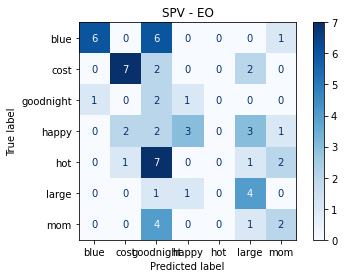

          AXL       AXL        AXL  ...        GZR        GZR        GZR
191  -1.00206 -0.999926  -0.924029  ...  0.0449337  0.0524529  0.0242557
175  0.771829  0.700575 -0.0611615  ...   0.697121   0.440087   0.339957
118  0.885556  0.964881   0.952939  ... -0.0931163  -0.106309   -0.10254
139 -0.442967 -0.435987  -0.451691  ...  -0.347785   -1.08366   -1.38703
169  -0.11358 -0.149508  0.0950052  ...    2.11772    1.91742     1.8284
..        ...       ...        ...  ...        ...        ...        ...
80  -0.460158 -0.215728   -0.73099  ... -0.0620349 -0.0845034 -0.0751415
21  -0.843122 -0.860139  -0.784771  ...   -1.89893   -2.29768   -0.17043
132 -0.773836 -0.728724  -0.759482  ... -0.0644518 -0.0584386  -0.055432
8    -1.24304  -1.27182   -1.25874  ...    1.12713   0.663952   0.219493
127  -1.24802   -1.2454   -1.21396  ...   -1.18744   -0.25435  -0.100252

[147 rows x 600 columns]
[[-5.93293545e+00  6.83731599e+00 -4.82411557e+00 ... -1.53816016e-01
  -2.04647792e-01  1.3183898

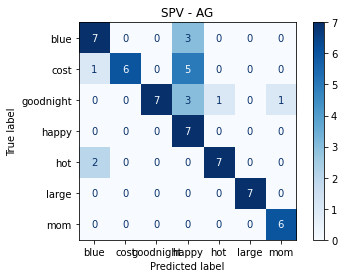

           AXL        AXL        AXL  ...       OYR       OYR       OYR
8     -1.24304   -1.27182   -1.25874  ... -0.876759 -0.791761 -0.706762
144   -0.72502  -0.721518  -0.676872  ... -0.192226 -0.192226 -0.192226
110  -0.797915  -0.864606  -0.744214  ...   1.26152    1.1691   1.07668
148   -1.12976    -1.1155   -1.11634  ...   1.92137   1.92137   1.92137
64     -0.7818  -0.486659   -0.48102  ...  -1.63887  -1.63887  -1.63887
..         ...        ...        ...  ...       ...       ...       ...
2    0.0267628  0.0255969  0.0116268  ...  -1.45278  -1.45278  -1.45278
111  -0.504482  -0.488851  -0.558322  ...   1.05354   1.38272    1.5238
123   0.405084   0.448695   0.428343  ...  -1.93481  -1.96662  -1.96662
19   -0.564784  -0.565611  -0.584648  ...  -1.01166  -1.01166  -1.01166
24    -1.40906   -1.38624   -1.38053  ...  -2.15961  -2.23619  -2.28724

[147 rows x 600 columns]
[[ 2.52831913e+00  9.28702262e+00 -4.50505197e+00 ...  1.88681559e-02
  -8.51453393e-03  2.02615702e-15]
 [-4.

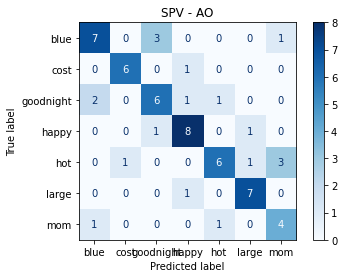

           GXL        GXL        GXL  ...       OYR       OYR       OYR
114  -0.975619  -0.660253  -0.847246  ...   -1.9454  -1.98453  -2.02366
27   0.0609938  0.0627807   0.044018  ... -0.523361 -0.441629 -0.400762
160    1.05306    2.08614   0.268014  ...   1.21567   1.25302   1.25302
140 -0.0936617  -0.125327  -0.126911  ...   1.69979   1.69979   1.69979
33    0.269941   0.371133   0.454522  ...   1.21966   1.21966   1.21966
..         ...        ...        ...  ...       ...       ...       ...
138 -0.0440408 -0.0564817  -0.103481  ...    1.6052   1.57549   1.51606
100  -0.524337   0.141183   0.421049  ... -0.402561 -0.402561 -0.402561
12    0.108563   0.129643 -0.0239349  ... -0.551974 -0.551974 -0.551974
63    -2.39603   -2.39603   -1.34036  ...  -1.65037  -1.65037  -1.65037
71    -2.04456   -2.06808   0.387397  ...   1.88635   1.88635   1.88635

[147 rows x 600 columns]
[[ 1.10552798e+01 -9.78271923e+00 -1.97013444e+00 ... -1.89101732e-02
  -4.06003594e-02  5.75928194e-16]
 [ 2.

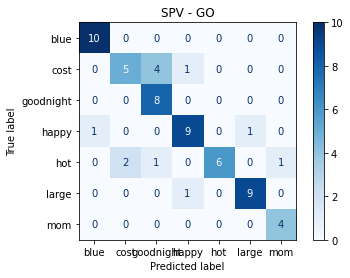

         EMG0L        EMG0L      EMG0L  ...        GZR        GZR        GZR
61   0.0826598  -0.00251497  -0.186338  ... -0.0455998 -0.0526632 -0.0617448
91   0.0451872  -0.00137485  -0.462039  ...  -0.382318  -0.367936  -0.412879
176  0.0442954  -0.00134771  -0.224114  ...   0.401314    0.30911   0.241621
112  0.0324087 -0.000986054  0.0764913  ...    2.45102   0.859235    1.07192
68   0.0739117  -0.00224881  -0.428925  ...  -0.059053  -0.078568 -0.0663711
..         ...          ...        ...  ...        ...        ...        ...
18    0.054564  -0.00166014  -0.135507  ...   -1.69485    -2.5171   -3.19011
145  0.0427288  -0.00130005 -0.0223332  ...  -0.206782  -0.171166 -0.0276222
44   0.0532847  -0.00162122  -0.185926  ...  0.0777897 -0.0467898  -0.013472
158   0.115251  -0.00350657  -0.810445  ...  0.0215695  0.0954299  0.0496686
51    0.020404 -0.000620804 -0.0602792  ... -0.0800295   0.085258 -0.0040214

[147 rows x 1400 columns]
[[ 1.26961854e+01 -2.23783723e+00  2.83391777e+00

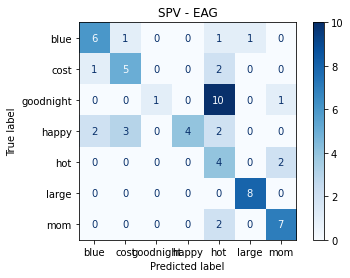

           EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
103     0.058362   -0.0017757   -2.61784  ... -0.668933 -0.668933 -0.668933
11     0.0527826  -0.00160594   -0.81441  ... -0.873818 -0.873818 -0.873818
187    0.0667616  -0.00203126 -0.0884108  ...  -1.85955  -1.85955  -1.85955
87     0.0629643  -0.00191573  -0.114154  ... -0.717748 -0.717748 -0.717748
9       0.109678  -0.00333703 -0.0573258  ... -0.689155 -0.689155 -0.689155
..           ...          ...        ...  ...       ...       ...       ...
26       0.04561  -0.00138771   0.153574  ...  -0.62857  -0.62857  -0.62857
188    0.0373573  -0.00113662    0.10985  ...   1.15608   1.15608   1.15608
115  0.000652685 -1.98583e-05  -0.120837  ...  -1.61801  -1.65713  -1.69625
98     0.0429738   -0.0013075  -0.237666  ...  0.329036  0.387307  0.387307
30     0.0451938  -0.00137505  0.0264547  ...   1.36268   1.36268   1.36268

[147 rows x 1400 columns]
[[ 8.93447990e+00 -1.00956586e+01  2.46853182e+00 ... -9.9051

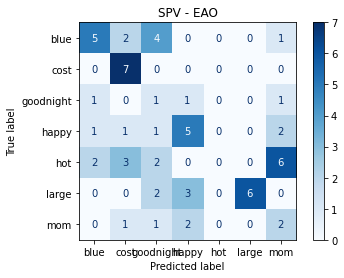

          EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
125   0.0697413  -0.00212192  -0.199908  ...  -1.99894  -1.99894  -1.99894
173   0.0647247  -0.00196929   0.623274  ...   0.14676   0.14676   0.14676
3     0.0284809 -0.000866548 -0.0836183  ...  -1.48877  -1.52993  -1.52993
128   0.0821461  -0.00249934  0.0462326  ...  0.725525  0.725525  0.725525
136   0.0461984  -0.00140561  -0.116313  ... -0.346949 -0.459717 -0.572485
..          ...          ...        ...  ...       ...       ...       ...
62   0.00419773 -0.000127719  -0.444061  ...  -1.74648  -1.74648  -1.74648
162   0.0341041  -0.00103764   -0.22867  ...   1.71385   1.71385   1.71385
74    0.0682517   -0.0020766   0.196081  ... -0.109504 -0.109504 -0.109504
32     0.017107  -0.00052049  -0.162138  ...   1.24407   1.24407   1.24407
75    0.0894808  -0.00272251    -0.1079  ...  0.347844  0.347844  0.347844

[147 rows x 1400 columns]
[[ 1.65357778e+01  1.08359610e+01 -1.04777246e+01 ... -3.88753964e-01
   

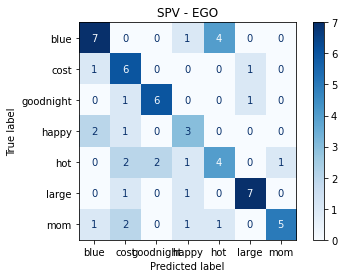

          AXL       AXL       AXL  ...       OYR       OYR       OYR
48  -0.998804 -0.981749  -1.04185  ...  -1.60322  -1.60322  -1.57472
159  -1.58131  -1.62752   -1.8335  ...   1.25442   1.28988   1.28988
108 -0.265531 -0.264645 -0.274389  ...   1.97546   1.91933    1.8632
88    -1.4345  -1.49986  -1.44808  ... -0.612949 -0.612949 -0.612949
165 -0.615889 -0.625349 -0.320045  ...  -1.30895  -1.23315  -1.23315
..        ...       ...       ...  ...       ...       ...       ...
13  -0.770127 -0.758621 -0.728896  ... -0.724292 -0.724292 -0.724292
120  -1.33558  -1.30345  -1.31648  ...   1.27895   1.27895   1.27895
200 -0.383115 -0.390041 -0.403026  ...   1.34487   1.31769   1.29051
63  -0.326053 -0.326053 -0.602496  ...  -1.65037  -1.65037  -1.65037
206  -1.29292  -1.29292   -1.2852  ...   2.16035   2.16035   2.16035

[147 rows x 900 columns]
[[ 4.85682953e+00 -1.03555864e+01 -3.58679904e+00 ... -5.99687265e-02
  -2.34631929e-02  1.43635104e-15]
 [-1.07951559e+01  3.37348068e+00  1.1988

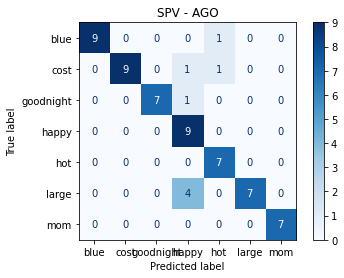

         EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
178  0.0706811 -0.00215052   0.637671  ...   2.12686   2.12686   2.12686
75   0.0894808 -0.00272251    -0.1079  ...  0.347844  0.347844  0.347844
175  0.0433094 -0.00131771   0.039679  ...   2.21455   2.21455   2.18714
106  0.0672849 -0.00204718  -0.035168  ...   1.80664   1.74835    1.7192
46   0.0458904 -0.00139624 -0.0239856  ...   1.32113   1.32113   1.28933
..         ...         ...        ...  ...       ...       ...       ...
149  0.0843766 -0.00256721    0.15983  ...   1.95426   1.95426   1.92922
28    0.066116 -0.00201162   0.414162  ... -0.699813 -0.658558 -0.617304
163  0.0510549 -0.00155338  0.0505978  ...   1.71286   1.71286   1.71286
125  0.0697413 -0.00212192  -0.199908  ...  -1.99894  -1.99894  -1.99894
23   0.0429441  -0.0550707  0.0329542  ...  -2.12221  -2.01998  -1.96887

[147 rows x 1700 columns]
[[-1.21917400e+01  4.06730451e-01 -4.67898828e+00 ... -5.82252639e-01
   1.41737245e+00  1.831867

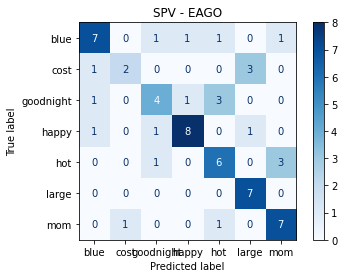

    EMG0L EMG0L     EMG0L     EMG0L  ...    EMG7R     EMG7R     EMG7R     EMG7R
180     0     0         0         0  ... -8.94309  -10.3283  -5.30382  -1.94971
66      0     0  0.355984  -2.51355  ...  -0.2219 -0.181234   0.97008   0.10348
81      0     0  -1.77992   3.31217  ...  1.64356  -2.43906    3.3256  -3.96306
84      0     0  -1.06795   1.48892  ...  4.38483  -13.7839   2.69403   8.89256
38      0     0  0.355984  -3.22552  ...  2.12422   1.75843   0.52149   3.61639
..    ...   ...       ...       ...  ...      ...       ...       ...       ...
44      0     0  -1.06795  0.776955  ... -1.02043  -3.76836 -0.309439  0.668488
178     0     0   3.91583    -6.646  ...  2.14055 -0.308489    1.9067   1.70272
193     0     0  0.711968  -5.73907  ...  3.64635   3.65807  0.904397  0.777754
48      0     0  -1.42394   6.49436  ... -4.19523  -1.48505   1.25055  -2.70893
74      0     0   1.77992  -2.95618  ...  1.52216   2.98593  -4.78682   2.93267

[147 rows x 800 columns]
[[ 7.97845506e

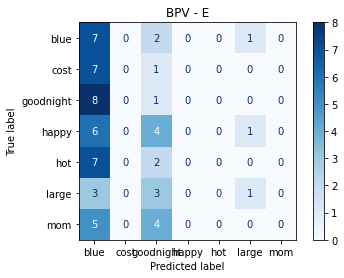

            AXL         AXL       AXL  ...       AZR       AZR       AZR
143   -0.217285   -0.217285 -0.189941  ...  0.583984   0.79834  0.828125
204   -0.341797   -0.349609  -0.32373  ...  0.785645  0.734863  0.806152
50    -0.592285   -0.689453 -0.293945  ...  0.641113  0.617188   1.07959
39    -0.352051    -0.32959 -0.200684  ...  0.854492  0.867188     0.875
197   -0.208984    -0.22168 -0.210449  ...  0.934082  0.977051  0.758789
..          ...         ...       ...  ...       ...       ...       ...
75   0.00146484  0.00146484 -0.012207  ...   0.99707   1.00195   1.00342
35    -0.300293   -0.248047  -0.14502  ...  0.944336  0.948242  0.949219
145    -0.19873   -0.200195 -0.180176  ...  0.650391  0.772949  0.816895
5        0.3125    0.312988  0.329102  ...  0.665039  0.675781  0.847168
8      -0.48877   -0.504883 -0.497559  ...  0.677246  0.809082  0.989258

[147 rows x 300 columns]
[[-2.53353788e+00  5.01296683e-01  2.42519330e-01 ...  3.38450626e-02
  -1.57538535e-03  6.1582683

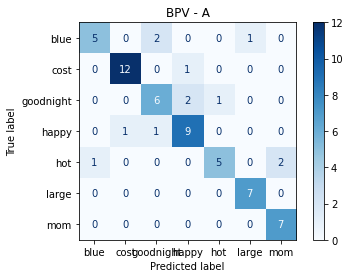

         GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
188   1.3125   1.0625   0.3125   2.1875  ...   0.9375  -0.0625     0.75   -0.625
110 -11.4375 -11.5625 -14.5625   -52.25  ...  35.5625    -0.75  -60.375      -64
198   0.1875   -0.375  -0.4375   -2.375  ...   -21.75 -33.3125 -28.8125    -42.5
9     0.0625   -0.875  -3.5625     -5.5  ...   9.6875   26.625  -8.4375     15.5
29      0.25  -4.0625    -5.25  -8.3125  ... -83.9375 -82.6875    -73.5 -50.8125
..       ...      ...      ...      ...  ...      ...      ...      ...      ...
209    -7.75       -6  12.6875  -1.4375  ...  -2.9375  -2.9375   -5.125      0.5
82     -30.5 -50.1875   42.125   131.75  ...    -6.25   1.1875   -2.125  -1.1875
142    -1.75  -1.0625   0.8125  -0.4375  ...    1.125   9.6875  -7.9375  -5.1875
154  57.6875  -26.875  -31.875   8.6875  ...  221.438  245.062  170.562  162.812
67   67.0625  89.0625  89.5625  83.4375  ...   0.6875  -1.0625  -1.4375    0.875

[147 rows x 300 columns]
[[

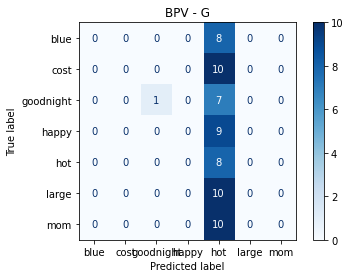

    ORL ORL ORL ORL ORL ORL ORL ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR  OYR
54   72  70  67  65  65  64  63  63  ...   39   39   39   39   39   39   39   38
9    74  74  74  74  74  74  74  73  ...   70   72   74   76   77   78   78   78
120  86  86  86  86  86  86  86  86  ...  140  141  140  140  140  140  140  140
94   87  85  85  85  85  86  88  88  ...   19   19   19   19   19   19   19   19
18   62  62  62  62  62  62  62  62  ...    5    7    9    9    8    7    4    0
..   ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...
101  89  89  88  88  88  88  88  90  ...   77   77   77   77   77   77   77   77
34   91  92  93  93  92  90  88  87  ...    6    5    5    5    5    5    5    5
206  72  72  72  72  72  72  72  73  ...  178  178  178  178  178  178  178  178
158  77  78  82  84  88  90  92  93  ...  116  117  118  120  120  121  121  122
31   76  77  77  77  77  77  77  77  ...  122  122  122  122  122  122  122  122

[147 rows x 300 columns]
[[

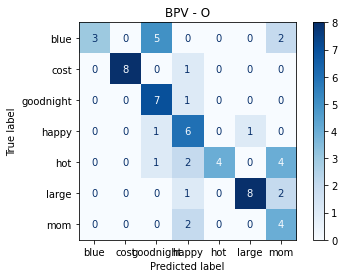

    EMG0L EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR       AZR
66      0     0  0.355984  -2.51355  ...  0.887695  0.886719  0.889648  0.883789
162     0     0  -1.77992   4.73611  ...  0.731934  0.715332  0.815918  0.742188
14      0     0  0.711968  -1.82325  ...  0.510742  0.395996  0.313477  0.347168
33      0     0 -0.355984  -4.60613  ...  0.844727  0.853027  0.854492  0.850586
121     0     0 -0.711968  0.755293  ...  0.789062  0.740723   0.78125   0.78418
..    ...   ...       ...       ...  ...       ...       ...       ...       ...
19      0     0  -1.42394  0.798617  ...  0.624512  0.629883  0.630371   0.62793
52      0     0 -0.355984 -0.334322  ...   0.57959  0.577637  0.576172  0.586914
161     0     0   16.0193  -16.9941  ...  0.708008  0.702637  0.708496  0.708984
183     0     0         0 -0.711968  ...   0.60498  0.657227  0.608398   0.61377
17      0     0         0 -0.355984  ...   1.03516   1.08398   1.13184   1.04346

[147 rows x 1100 columns]
[

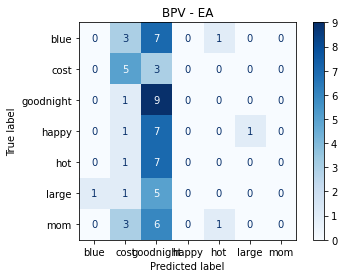

    EMG0L EMG0L     EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
104     0     0 -0.711968   0.755293  ... -144.562 -116.938 -31.5625     14.5
144     0     0 -0.355984   0.733631  ...      7.5       -2    -9.25   1.0625
75      0     0 -0.355984   0.377646  ...   1.1875     1.25   1.1875    0.375
20      0     0  0.355984    -1.4456  ...    3.625 -24.4375 -84.3125  -114.25
16      0     0 -0.355984  0.0216621  ...   -76.25 -95.5625 -118.688 -128.812
..    ...   ...       ...        ...  ...      ...      ...      ...      ...
70      0     0  0.711968   -2.17923  ...       15   6.4375  -1.4375   5.6875
22      0     0 -0.711968    1.11128  ...   -42.25 -69.3125   -120.5 -159.375
132     0     0   2.13591   -3.33383  ...    0.375  -0.5625  -0.3125  -0.1875
192     0     0  0.711968 -0.0433241  ...   0.5625        3  -0.0625    1.375
140     0     0 -0.711968   0.755293  ...     43.5  33.1875  11.9375  -0.5625

[147 rows x 1100 columns]
[[-5.37117347e+09  5.34193680e+00  4.

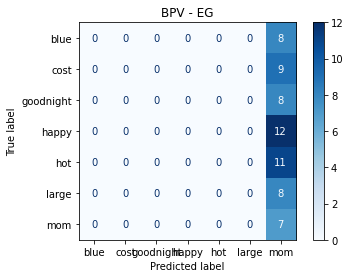

    EMG0L EMG0L     EMG0L      EMG0L       EMG0L  ...  OYR  OYR  OYR  OYR  OYR
42      0     0         0  -0.711968     1.11128  ...   72   72   72   72   72
138     0     0 -0.355984   0.377646 -0.00584961  ...  155  154  153  152  150
162     0     0  -1.77992    4.73611    -6.61026  ...  160  160  160  160  160
129     0     0 -0.355984   0.733631   -0.383496  ...  123  122  122  122  122
133     0     0  0.711968    1.02463    -5.79236  ...   69   69   69   69   69
..    ...   ...       ...        ...         ...  ...  ...  ...  ...  ...  ...
57      0     0         0   0.355984    -2.51355  ...   93   93   93   93   93
146     0     0         0          0   -0.355984  ...  179  179  179  179  178
175     0     0  0.355984   -1.08961     1.82909  ...  172  172  173  173  172
36      0     0  -17.0872    35.9262    -6.70365  ...    4    4    4    4    4
147     0     0 -0.711968  0.0433241     2.16753  ...    1    1    0    0  179

[147 rows x 1100 columns]
[[ 1.04456270e+02  2.7132

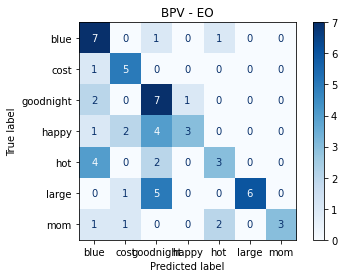

            AXL         AXL        AXL  ...      GZR      GZR      GZR
193   -0.097168  -0.0961914 -0.0776367  ...  -0.9375      8.5      9.5
41     0.358398    0.356934   0.368164  ...  -0.8125    -0.75   -0.875
137   -0.188965   -0.190918  -0.192871  ... -23.8125  -35.125 -33.5625
138  -0.0615234  -0.0620117 -0.0712891  ... -57.9375 -61.4375 -66.8125
205   -0.357422   -0.362305  -0.358887  ...   3.6875   2.4375   -0.375
..          ...         ...        ...  ...      ...      ...      ...
158  -0.0517578 -0.00439453     0.3125  ...    1.125    6.875   3.3125
27    -0.708984   -0.690918  -0.630859  ... -35.8125 -24.9375     28.5
187    0.217773    0.196777   0.182617  ...  -11.875   -5.125  -0.0625
86    -0.592285   -0.624023  -0.300293  ...   0.1875   -0.125    0.375
75   0.00146484  0.00146484  -0.012207  ...     1.25   1.1875    0.375

[147 rows x 600 columns]
[[-5.37117350e+09 -9.01202695e+01 -5.24126822e+01 ...  1.15646990e+01
   2.63731920e-01  1.62659566e-06]
 [-5.37117346e+09

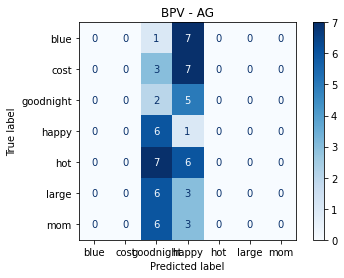

           AXL       AXL        AXL       AXL  ...  OYR  OYR  OYR  OYR
107  0.0151367   0.15332   0.116211  0.097168  ...  166  164  163  162
155   0.334961  0.344238   0.353516  0.355469  ...  174  178    3    7
110  -0.176758 -0.214355  -0.146484  0.161133  ...  106  105  103  101
3     0.388672  0.375977   0.375488  0.390137  ...   44   44   43   43
172   -0.18457 -0.270996  0.0786133  0.176758  ...   77   77   77   76
..         ...       ...        ...       ...  ...  ...  ...  ...  ...
43   0.0771484  0.149902   0.220703  0.228027  ...   71   71   71   71
0    -0.579102  -0.59082  -0.603027 -0.619141  ...  111  111  112  113
93   -0.555176 -0.554199  -0.589355 -0.539551  ...  138  137  135  134
174  -0.241699 -0.210449  -0.201172 -0.495117  ...   79   78   78   78
144  -0.203613  -0.20166  -0.176758  -0.18457  ...   81   81   81   81

[147 rows x 600 columns]
[[-5.47861218e+02  7.91672243e+01  9.60457172e+01 ...  5.89760251e-02
  -3.70914369e-02 -1.27675648e-14]
 [ 3.91096921e+01

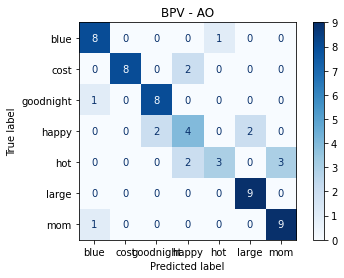

         GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
13    1.9375       -2  -5.5625  -6.8125  -1.3125  ...   79   79   79   79   79
61    7.1875  20.6875    9.625   25.125  10.9375  ...  116  116  116  116  116
69   -19.625 -42.1875  22.9375  101.062  49.4375  ...   85   85   85   85   84
44    -72.75  -85.625  -37.625 -13.3125     -6.5  ...  140  140  140  140  140
138    -1.25  -1.8125  -3.9375   -2.375  -0.5625  ...  155  154  153  152  150
..       ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
177    94.75   62.125  79.3125   107.75  143.062  ...  171  172  173  173  174
149    6.375   0.5625   0.9375    6.125        4  ...  173  173  173  173  172
165  -42.125     4.25 -14.0625  -32.625       -3  ...   49   50   50   51   51
178  103.625  109.125      137  109.938  73.8125  ...  172  172  172  172  172
196  -1.8125  -2.1875       -3  -2.8125        0  ...   54   53   53   53   53

[147 rows x 600 columns]
[[-5.37117350e+09  2.21597

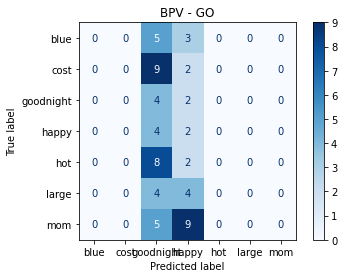

    EMG0L EMG0L     EMG0L     EMG0L  ...     GZR      GZR      GZR      GZR
72      0     0         0         0  ...  -0.375   0.1875  -0.4375   0.4375
57      0     0         0  0.355984  ...  -0.375  -0.6875        0    0.125
32      0     0  -1.06795   1.84491  ...  -4.375  -2.1875    0.625   1.9375
108     0     0         0  -1.77992  ...  -66.75 -67.8125 -69.9375 -75.3125
180     0     0         0         0  ...   -9.25   -13.25 -14.1875 -15.5625
..    ...   ...       ...       ...  ...     ...      ...      ...      ...
136     0     0 -0.711968   1.82325  ... -9.3125 -23.3125   -27.25 -31.4375
12      0     0  0.711968  -2.53521  ... -0.4375   0.1875   0.5625   0.1875
128     0     0  0.355984   -1.4456  ... -1.5625    2.875   0.3125    0.875
132     0     0   2.13591  -3.33383  ...   0.375  -0.5625  -0.3125  -0.1875
143     0     0 -0.355984  0.377646  ...  -0.375  -5.4375  -5.8125    1.125

[147 rows x 1400 columns]
[[-5.16421859e+16 -1.44499026e+01  1.57729586e+02 ...  3.3827

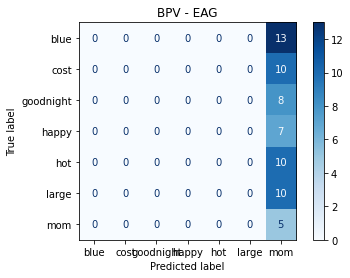

    EMG0L EMG0L     EMG0L     EMG0L      EMG0L  ...  OYR  OYR  OYR  OYR  OYR
77      0     0 -0.711968  0.755293    1.05625  ...  158  157  155  154  153
195     0     0         0  -1.06795    2.55688  ...   56   55   54   53   53
13      0     0 -0.355984  0.377646   0.706119  ...   79   79   79   79   79
14      0     0  0.711968  -1.82325  0.0766854  ...   61   57   56   56   57
104     0     0 -0.711968  0.755293  -0.367683  ...   79   78   74   71   68
..    ...   ...       ...       ...        ...  ...  ...  ...  ...  ...  ...
66      0     0  0.355984  -2.51355     5.1196  ...   82   82   82   82   82
170     0     0   3.20386  -7.67063    3.16047  ...  123  125  130  133  135
109     0     0         0  -1.06795    2.55688  ...  171  169  167  165  164
184     0     0 -0.711968   1.11128 -0.0333613  ...   16   16   16   16   16
74      0     0   1.77992  -2.95618    -1.3297  ...   84   83   84   84   84

[147 rows x 1400 columns]
[[-2.23151134e+02 -1.48155151e+02 -1.20724934e+02

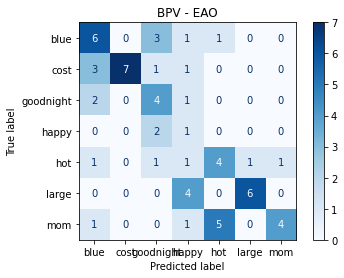

    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
137     0     0 -0.355984    1.08961  -1.47311  ...   69   67   66   64   62
37      0     0 -0.355984  -0.334322   3.59732  ...   69   69   69   69   69
89      0     0  -1.42394  -0.269336   4.71271  ...   83   83   83   83   83
13      0     0 -0.355984   0.377646  0.706119  ...   79   79   79   79   79
1       0     0 -0.355984  0.0216621  0.727781  ...  113  115  116  117  117
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
71      0     0  -3.55984    6.26835   1.92577  ...  117  117  117  117  117
33      0     0 -0.355984   -4.60613   9.55301  ...  122  122  122  122  122
42      0     0         0  -0.711968   1.11128  ...   72   72   72   72   72
81      0     0  -1.77992    3.31217  0.596072  ...   35   35   35   35   35
120     0     0 -0.711968   0.755293   1.05625  ...  140  140  140  140  140

[147 rows x 1400 columns]
[[-5.16421859e+16 -5.40796236e+09  7.97455575e+01

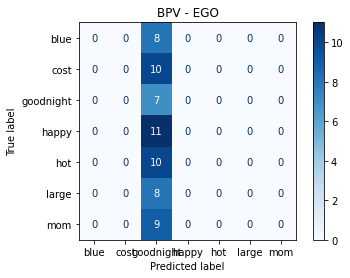

            AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
5        0.3125   0.312988   0.329102   0.321777  ...   46   45   44   42
89     0.200195   0.237305   0.185059   0.177246  ...   83   83   83   83
38    -0.513672  -0.519531  -0.245605  -0.163574  ...   70   70   70   70
74   -0.0224609  -0.078125 -0.0717773 -0.0268555  ...   83   84   84   84
120   -0.552734  -0.534668  -0.541992  -0.561035  ...  140  140  140  140
..          ...        ...        ...        ...  ...  ...  ...  ...  ...
20    -0.325684  -0.325195  -0.313477  -0.297363  ...   50   51   52   53
31  -0.00634766  0.0439453   0.132324   0.147949  ...  122  122  122  122
152   -0.695801  -0.710938   -0.77832  -0.815918  ...  141  141  141  141
159   -0.478027  -0.501465  -0.605957  -0.498535  ...  126  127  128  128
190   -0.332031  -0.328613  -0.371582  -0.354492  ...  129  129  129  129

[147 rows x 900 columns]
[[-5.16421859e+16 -5.40796237e+09 -9.25235275e+01 ...  1.83503440e+02
  -3.12550651e-0

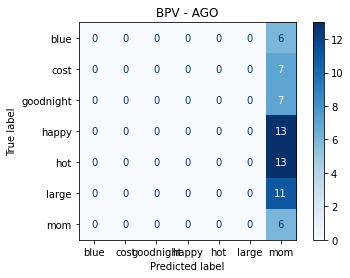

    EMG0L EMG0L     EMG0L     EMG0L      EMG0L  ...  OYR  OYR  OYR  OYR  OYR
188     0     0  0.711968  -1.82325   0.788654  ...  133  133  133  133  133
45      0     0 -0.711968   2.53521   -3.32387  ...  144  142  141  140  140
67      0     0  -1.06795   1.13294    3.18631  ...   83   83   83   83   83
203     0     0  0.355984  0.690306   -3.26299  ...   87   87   87   86   86
94      0     0  -1.42394  0.798617    2.51182  ...   19   19   19   19   19
..    ...   ...       ...       ...        ...  ...  ...  ...  ...  ...  ...
169     0     0  0.355984  -2.15757    1.18211  ...  118  122  125  129  132
92      0     0  -1.42394    5.7824   -10.2509  ...  135  135  133  132  131
99      0     0  -1.06795   1.84491   -1.48481  ...  101  102  102  102  102
184     0     0 -0.711968   1.11128 -0.0333613  ...   16   16   16   16   16
29      0     0  0.355984 -0.733631  -0.328473  ...   69   71   73   75   76

[147 rows x 1700 columns]
[[-5.16421859e+16 -5.40796236e+09 -7.48626648e+01

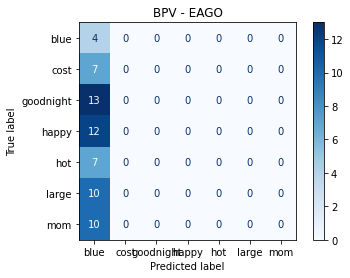

        EMG0L     EMG0L     EMG0L  ...        EMG7R        EMG7R        EMG7R
188  0.171301 -0.181725 -0.163133  ...  -0.00637009  -0.00230173   0.00109024
100  0.190128 -0.197652 -0.203431  ...    -0.052164    0.0397674    0.0482076
207  0.134697 -0.142893 -0.132483  ...   -0.0916344    0.0174016   -0.0348711
179  0.105948 -0.112395  -0.11692  ...  -0.00888518 -0.000741917  -0.00489084
176  0.151024 -0.160214 -0.159329  ...    -0.169894   -0.0387866    0.0163714
..        ...       ...       ...  ...          ...          ...          ...
184  0.214934 -0.228013  -0.21476  ...   -0.0166425   -0.0344541   -0.0110554
31   0.204332 -0.216766 -0.186607  ...   -0.0125582   -0.0149379    -0.022446
26   0.207874 -0.220523 -0.196663  ...    0.0180921    0.0202683   -0.0297125
37   0.154776 -0.164194 -0.155328  ...  0.000282281   0.00503666 -0.000330308
60   0.209871 -0.222642 -0.209079  ...  -0.00616695  6.92413e-05  -0.00720323

[147 rows x 800 columns]
[[ 1.37858260e-01 -1.39096259e-01  5.3

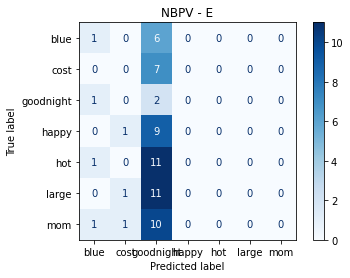

           AXL       AXL        AXL  ...       AZR       AZR       AZR
178   0.467245  0.505219   0.575839  ...  0.832335  0.824118  0.838997
80    0.480071  0.526198   0.428962  ...  0.742526  0.749437  0.757955
101   0.158937  0.177651   0.217521  ...  0.839709  0.839166   0.84215
189   0.232922   0.23059   0.221264  ...  0.787598  0.779671  0.781769
71    0.404505   0.43422   0.410736  ...  0.747184  0.748862  0.745028
..         ...       ...        ...  ...       ...       ...       ...
155   0.478649  0.482192   0.485735  ...  0.766735    0.6694  0.716762
17    0.393998  0.394718   0.395919  ...  0.955101  0.978635  0.935177
21    0.265399  0.261836   0.277617  ...  0.731376  0.532835         1
130   0.242761  0.238374   0.238959  ...  0.879204  0.873939  0.887687
180  0.0867177  0.090301  0.0919733  ...  0.802438  0.805065  0.798377

[147 rows x 300 columns]
[[ 8.95669502e-01 -1.84451174e+00  9.87250460e-02 ...  1.17596970e-03
  -8.66314275e-04  6.27969898e-16]
 [ 7.16596168e-01

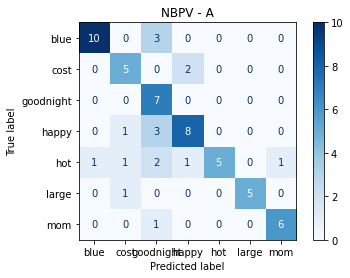

          GXL       GXL       GXL  ...       GZR       GZR       GZR
23   0.528381  0.515689  0.496415  ...  0.697614  0.719119  0.664472
54    0.26322  0.299755  0.250147  ...  0.454651  0.451966  0.453484
144  0.437768  0.438286  0.438027  ...  0.433494   0.41847   0.43984
27    0.47749  0.477759  0.474937  ...  0.392152  0.415536   0.53044
159  0.560203  0.552318  0.602164  ...  0.609381  0.590939  0.584124
..        ...       ...       ...  ...       ...       ...       ...
12   0.504137  0.506769  0.487589  ...  0.492102  0.493231  0.492102
204  0.487966  0.479361  0.503295  ...  0.492269  0.496841   0.49321
127  0.390683  0.391228  0.383736  ...  0.243428   0.36303  0.382782
136  0.538306  0.539312  0.538306  ...  0.458475  0.445806  0.432334
32    0.48972  0.537692  0.513799  ...   0.54862  0.552787  0.554732

[147 rows x 300 columns]
[[ 4.70002282e-01  3.35828982e-01  6.39948506e-01 ...  5.08534207e-03
  -6.11263415e-04  7.73686670e-16]
 [-3.36261260e-01 -3.94742209e-01  5.5445

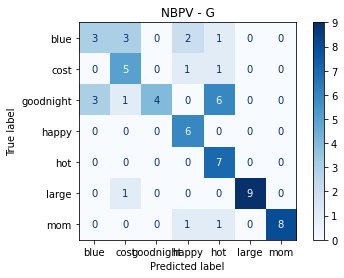

          ORL       ORL       ORL  ...        OYR        OYR        OYR
115  0.473214  0.464286    0.4375  ...   0.142857   0.133929      0.125
121  0.265625  0.257812  0.257812  ...   0.632812   0.632812   0.632812
200  0.346369  0.346369  0.346369  ...   0.826816   0.821229   0.815642
66   0.618557  0.628866  0.649485  ...   0.474227   0.474227   0.474227
133  0.860465  0.860465  0.860465  ...   0.372093   0.372093   0.372093
..        ...       ...       ...  ...        ...        ...        ...
167       0.6       0.6  0.569231  ...   0.169231   0.184615        0.2
19   0.219512  0.219512  0.219512  ...  0.0609756  0.0609756  0.0609756
22   0.217949  0.217949  0.217949  ...   0.102564  0.0897436  0.0897436
129  0.346457  0.346457  0.346457  ...   0.708661   0.708661   0.708661
191  0.868687  0.868687  0.868687  ...    0.20202    0.20202    0.20202

[147 rows x 300 columns]
[[ 2.75280590e+00 -9.74367450e-01  1.34403661e+00 ... -1.57050519e-04
  -4.85810229e-05  6.37510877e-16]
 [-3.

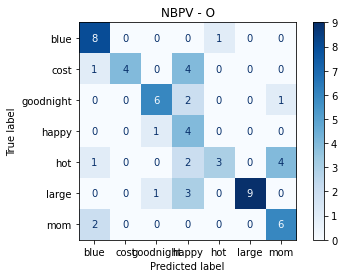

        EMG0L     EMG0L      EMG0L  ...       AZR       AZR       AZR
39   0.100048 -0.106136 -0.0867704  ...   0.73704  0.742752  0.746267
97   0.202515 -0.214839  -0.203934  ...  0.870728  0.879548  0.878721
120  0.137459 -0.145824   -0.14225  ...  0.840471  0.843233  0.843924
144  0.160013  -0.16975  -0.159182  ...  0.715002  0.803657  0.867018
35   0.171854 -0.182312  -0.181306  ...  0.838198  0.840008  0.840461
..        ...       ...        ...  ...       ...       ...       ...
133  0.221383 -0.234855  -0.214203  ...  0.876424  0.879106  0.876873
150  0.177992 -0.188823  -0.207927  ...  0.755254  0.804745  0.808587
31   0.204332 -0.216766  -0.186607  ...  0.720862  0.725256  0.724419
108  0.214784 -0.227854  -0.211254  ...  0.744817  0.762245  0.787561
111  0.200475 -0.212674  -0.199055  ...  0.801622  0.881086  0.863001

[147 rows x 1100 columns]
[[-6.88872512e-01 -1.48339892e-01 -6.00039968e-01 ... -1.98814124e-01
  -3.62929730e-02  6.27969898e-16]
 [ 2.00681878e+00  8.2585817

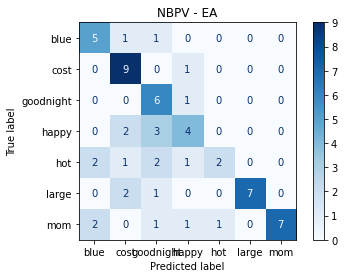

        EMG0L     EMG0L     EMG0L  ...       GZR       GZR       GZR
101  0.196556 -0.208516 -0.178038  ...  0.475674  0.477452  0.476806
128   0.22465  -0.23832 -0.217503  ...  0.392946  0.387297  0.388537
198  0.195217 -0.207096 -0.180526  ...  0.453435  0.464428  0.430993
90   0.214299 -0.227339 -0.221404  ...  0.420369  0.422054  0.421573
140  0.214056 -0.227081 -0.215192  ...   0.56325   0.49399  0.453248
..        ...       ...       ...  ...       ...       ...       ...
133  0.221383 -0.234855 -0.214203  ...  0.586949  0.586471  0.585515
117  0.187087 -0.198471 -0.160627  ...  0.362822  0.432285  0.448995
81   0.214014 -0.227037 -0.221092  ...  0.374695  0.379331  0.374695
5    0.147643 -0.156627 -0.146858  ...  0.380125  0.436226   0.22415
9    0.200743 -0.212958 -0.197444  ...  0.539322  0.468048  0.516707

[147 rows x 1100 columns]
[[ 3.77290361e-02  2.46253120e-01  7.22878297e-01 ... -3.13272689e-02
   4.29856496e-03  8.01442246e-16]
 [ 1.47671306e+00 -1.15175995e+00 -1.548

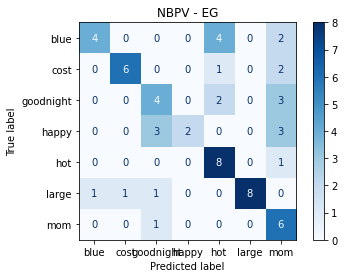

        EMG0L     EMG0L     EMG0L  ...         OYR        OYR        OYR
92    0.19041 -0.201997  -0.19556  ...    0.778846   0.769231   0.759615
209  0.148327 -0.157353 -0.150834  ...    0.983146   0.983146   0.983146
194  0.162951 -0.172866 -0.137711  ...  0.00628931          0          0
108  0.214784 -0.227854 -0.211254  ...    0.906977   0.891473   0.875969
205  0.188601 -0.200078 -0.187859  ...     0.55914    0.55914    0.55914
..        ...       ...       ...  ...         ...        ...        ...
190  0.215748 -0.228877 -0.205011  ...    0.747967   0.747967   0.747967
122  0.172788 -0.191629 -0.154869  ...   0.0162602  0.0162602  0.0162602
138  0.175992 -0.186702   -0.1751  ...    0.853107   0.847458   0.836158
163  0.176329 -0.187058 -0.170104  ...    0.918605   0.918605   0.918605
152  0.186585 -0.197939 -0.173699  ...    0.755556   0.755556   0.755556

[147 rows x 1100 columns]
[[-4.35363100e+00  1.20471427e+00  1.47490623e+00 ... -4.72142657e-03
  -8.91121651e-02  7.788908

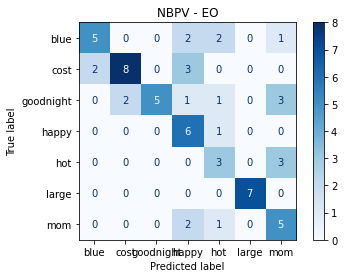

          AXL         AXL       AXL  ...          GZR          GZR          GZR
170  0.461322    0.576058  0.547536  ...     0.807317     0.749729     0.714778
110  0.427543    0.417288  0.435801  ...     0.487753     0.327686     0.317954
61          0  0.00484163  0.106996  ...     0.412764      0.41182     0.410605
157  0.697866    0.691419  0.569364  ...     0.794758     0.734711      0.59742
104  0.344016     0.33082   0.35509  ...     0.281789     0.517795     0.645128
..        ...         ...       ...  ...          ...          ...          ...
57   0.365406    0.397027  0.421622  ...  5.49789e-17  5.54582e-17  5.55453e-17
63   0.435283    0.435283  0.367112  ...     0.443398     0.462084     0.459544
109  0.458028    0.464444  0.474247  ...     0.207782     0.221701     0.221198
152  0.156598    0.149712  0.119059  ...     0.464592     0.464864     0.459427
162  0.377472    0.386327  0.479202  ...     0.579655     0.588356     0.585041

[147 rows x 600 columns]
[[-2.93561431e

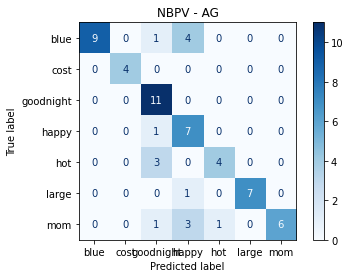

           AXL        AXL        AXL  ...         OYR        OYR        OYR
89    0.520114   0.533703   0.514571  ...    0.432099   0.432099   0.432099
131   0.318702    0.31684   0.322958  ...   0.0136986  0.0136986  0.0136986
133   0.390838   0.397542   0.412514  ...    0.372093   0.372093   0.372093
92   0.0748665  0.0845892          0  ...    0.778846   0.769231   0.759615
194   0.113289   0.128185   0.107409  ...  0.00628931          0          0
..         ...        ...        ...  ...         ...        ...        ...
207  0.0912604  0.0956431  0.0977053  ...     0.98324    0.98324   0.977654
19    0.526654   0.526525   0.523564  ...   0.0609756  0.0609756  0.0609756
40    0.120916   0.134252   0.242277  ...    0.326733   0.326733   0.326733
91    0.308269   0.340827   0.413695  ...    0.745098   0.745098   0.735294
13    0.168415   0.171728   0.180287  ...    0.537037   0.537037   0.537037

[147 rows x 600 columns]
[[ 1.95070246e-01 -1.33895328e+00  1.29462030e-01 ...  1.91291

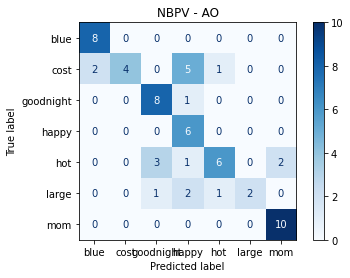

          GXL       GXL       GXL  ...        OYR        OYR        OYR
116  0.379708  0.295347  0.236803  ...  0.0860215  0.0752688  0.0645161
146  0.555054  0.550968  0.541075  ...          1          1   0.994413
99   0.544113   0.51973  0.632659  ...       0.75       0.75       0.75
157  0.555956  0.540563  0.544862  ...          0  0.0225989  0.0338983
32    0.48972  0.537692  0.513799  ...   0.736264   0.736264   0.736264
..        ...       ...       ...  ...        ...        ...        ...
120  0.482822  0.481423  0.462148  ...   0.786517   0.786517   0.786517
38   0.485488  0.503958  0.482355  ...   0.320755   0.320755   0.320755
78   0.481735   0.46181  0.500489  ...   0.871508   0.860335   0.854749
31   0.610684  0.607758  0.618811  ...   0.736264   0.736264   0.736264
167  0.548646  0.516062  0.481643  ...   0.169231   0.184615        0.2

[147 rows x 600 columns]
[[ 3.66875508e+00  1.53373643e-02 -3.08488736e-01 ...  6.51379632e-03
  -2.07624642e-03  1.08246745e-15]
 [ 4.

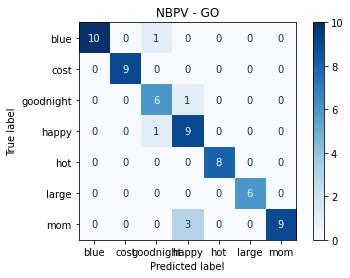

        EMG0L     EMG0L     EMG0L  ...          GZR          GZR          GZR
61   0.177992 -0.188823  -0.18166  ...     0.412764      0.41182     0.410605
30   0.134876 -0.143083 -0.130449  ...       0.4758     0.481487     0.483786
165  0.169399 -0.179708 -0.176436  ...     0.756258     0.768289     0.754092
24   0.151024 -0.160214 -0.148542  ...     0.328883     0.422882       0.4562
127   0.19827 -0.210335 -0.204024  ...     0.243428      0.36303     0.382782
..        ...       ...       ...  ...          ...          ...          ...
202  0.159935 -0.169667 -0.162466  ...     0.205339     0.271276     0.285421
25   0.142977 -0.151678 -0.140628  ...  6.76154e-10  1.38252e-09  1.90196e-09
34   0.189738 -0.201284 -0.177585  ...     0.529245     0.527072     0.531417
7    0.170498 -0.180873  -0.16957  ...     0.480776      0.49915     0.552116
148  0.194372   -0.2062 -0.193362  ...     0.351506     0.358042     0.353578

[147 rows x 1400 columns]
[[ 1.54793718e+00  1.49818508e+00 -3.

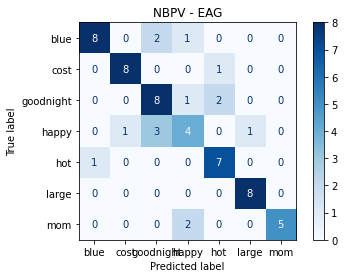

        EMG0L     EMG0L     EMG0L  ...        OYR        OYR         OYR
157     0.202 -0.214292 -0.246698  ...          0  0.0225989   0.0338983
48   0.201131  -0.21337 -0.204946  ...          0          0  0.00892857
15   0.163753 -0.173717  -0.19666  ...   0.464286   0.464286    0.464286
103  0.158456 -0.168099 -0.299115  ...   0.378788   0.378788    0.378788
81   0.214014 -0.227037 -0.221092  ...        0.1        0.1         0.1
..        ...       ...       ...  ...        ...        ...         ...
20   0.182131 -0.193214 -0.177069  ...  0.0394737  0.0526316   0.0657895
29   0.188945 -0.200443 -0.183102  ...   0.234568   0.259259    0.271605
119  0.186605  -0.19796 -0.174926  ...   0.985075   0.985075    0.985075
105  0.201208 -0.213452 -0.197902  ...        0.5        0.5         0.5
85   0.159694 -0.169411 -0.153743  ...  0.0733945  0.0642202   0.0458716

[147 rows x 1400 columns]
[[-1.46253769e+00  8.25673521e-01 -1.49595071e+00 ...  1.07426473e-02
   3.00263343e-02  1.096345

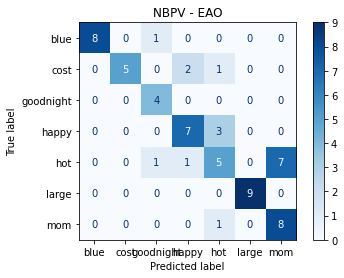

        EMG0L     EMG0L     EMG0L  ...         OYR         OYR         OYR
9    0.200743 -0.212958 -0.197444  ...    0.376623    0.376623    0.376623
77   0.192825 -0.204558 -0.199545  ...    0.865922    0.860335    0.854749
98   0.204589 -0.217038  -0.20941  ...        0.72    0.733333    0.733333
30   0.134876 -0.143083 -0.130449  ...    0.741935    0.741935    0.741935
82   0.183925 -0.195117 -0.191286  ...   0.0816327   0.0816327   0.0816327
..        ...       ...       ...  ...         ...         ...         ...
131  0.210227 -0.223019 -0.184348  ...   0.0136986   0.0136986   0.0136986
184  0.214934 -0.228013  -0.21476  ...  0.00763359  0.00763359  0.00763359
164  0.202349 -0.214662 -0.185909  ...     0.19403    0.208955    0.208955
100  0.190128 -0.197652 -0.203431  ...    0.444444    0.444444    0.444444
103  0.158456 -0.168099 -0.299115  ...    0.378788    0.378788    0.378788

[147 rows x 1400 columns]
[[-9.78357322e-01 -3.52709740e+00 -8.44218739e-01 ...  1.20912289e-01
   

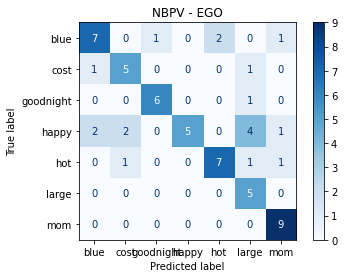

           AXL        AXL        AXL  ...        OYR        OYR        OYR
176   0.877972   0.842174   0.903057  ...   0.960894   0.955307   0.955307
167   0.300901   0.301962   0.288706  ...   0.169231   0.184615        0.2
28   0.0949289  0.0910278  0.0927615  ...     0.2375       0.25     0.2625
108   0.506879   0.507062   0.505044  ...   0.906977   0.891473   0.875969
43    0.405274   0.434376   0.462696  ...   0.384615   0.384615   0.384615
..         ...        ...        ...  ...        ...        ...        ...
174   0.383495   0.396633   0.400534  ...   0.546392   0.546392   0.546392
172   0.436371   0.401982   0.541093  ...   0.533333   0.533333   0.522222
203    0.31829    0.31829   0.315516  ...   0.568182   0.556818   0.556818
42    0.271232   0.308296   0.389788  ...   0.482759   0.482759   0.482759
131   0.318702    0.31684   0.322958  ...  0.0136986  0.0136986  0.0136986

[147 rows x 900 columns]
[[ 1.14538137e+00 -9.96383802e-01  4.02034403e-01 ... -8.10345880e-04
  -7

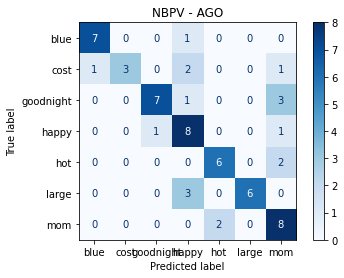

        EMG0L     EMG0L      EMG0L  ...        OYR        OYR        OYR
42   0.139056 -0.147518  -0.136771  ...   0.482759   0.482759   0.482759
19    0.17869 -0.189564  -0.181338  ...  0.0609756  0.0609756  0.0609756
35   0.171854 -0.182312  -0.181306  ...  0.0162602  0.0162602  0.0162602
130  0.106205 -0.112668 -0.0592245  ...          0          0          0
22   0.188289 -0.199747  -0.188137  ...   0.102564  0.0897436  0.0897436
..        ...       ...        ...  ...        ...        ...        ...
86   0.175295 -0.185962  -0.140053  ...   0.329114   0.329114   0.329114
45   0.204253 -0.216682  -0.204787  ...   0.756522   0.747826   0.747826
7    0.170498 -0.180873   -0.16957  ...    0.30137    0.30137    0.30137
54   0.195319 -0.207204  -0.182658  ...       0.01       0.01          0
66   0.212442  -0.22537   -0.20321  ...   0.474227   0.474227   0.474227

[147 rows x 1700 columns]
[[ 2.03282345e+00 -1.84396987e+00  1.94683945e-01 ...  7.72077470e-03
   2.01974073e-02  1.582067

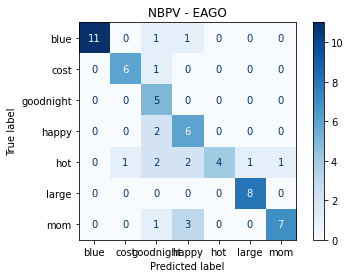

          EMG0L       EMG0L      EMG0L  ...      EMG7R      EMG7R      EMG7R
59    0.0491121    0.794275   -1.52528  ... -0.0848633  -0.247404  -0.163481
48    0.0129321   -0.013719  -0.101524  ... -0.0926151  0.0779909  -0.168943
53    0.0299311  -0.0317524  -0.128933  ...  0.0377377    1.30459   -0.40459
161   0.0218862  -0.0232181    1.24929  ...  -0.244451 -0.0252027   0.710177
39  -0.00626228  0.00664335   0.214902  ...  -0.396479    -0.1562  -0.117699
..          ...         ...        ...  ...        ...        ...        ...
113   0.0101173  -0.0107329  0.0341569  ...  -0.592967   0.368799  0.0508288
142    0.013389  -0.0142038  -0.013169  ...    1.07741  -0.185647  -0.289968
13    0.0592395  -0.0628443  -0.120871  ...   0.167147  -0.690617   -1.16834
133    0.029955  -0.0317778  0.0269231  ...  -0.817205   0.248713  -0.697725
46    0.0273802  -0.0290464 -0.0269303  ...   -0.34619  -0.407009   0.139801

[147 rows x 800 columns]
[[-2.77286248e+00 -1.51115210e+00  2.97545236e+00 

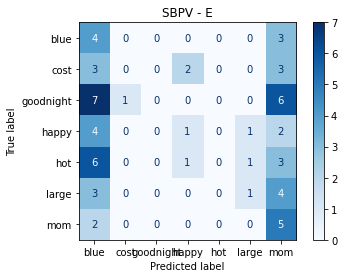

          AXL       AXL       AXL  ...       AZR       AZR       AZR
65  -0.536002 -0.507837 -0.522925  ...   1.28569   1.27362   1.23841
23   -1.53979  -1.51249  -1.43969  ...   1.17612   1.37797   1.54755
54   -1.30232  -1.30878  -1.11318  ...   1.04571    1.1039   1.06592
39  -0.998366 -0.958814 -0.731817  ...   1.12629   1.14865   1.16241
15   -0.76049 -0.775087 -0.739081  ...    1.3911   1.38621   1.39401
..        ...       ...       ...  ...       ...       ...       ...
159  -1.58131  -1.62752   -1.8335  ...   2.04168   1.07626  0.608461
149  -1.11748   -1.0891  -1.14754  ...   1.19881   1.06938   1.12867
195 -0.632269 -0.646972 -0.635728  ...   1.78245    1.1312   1.24796
5   -0.246558 -0.245401 -0.207196  ...  0.589284  0.614753    1.0211
6   -0.654892 -0.674799  -0.65091  ...   1.12473   3.31999   1.89709

[147 rows x 300 columns]
[[ 7.61707257e+00  9.45639615e-01 -6.24445424e-01 ... -5.94842426e-03
  -2.18987304e-02  1.04083409e-15]
 [ 7.54248324e-01 -7.38384829e+00  3.0866

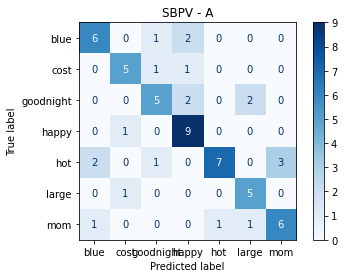

            GXL         GXL        GXL  ...        GZR        GZR        GZR
113 -0.00204534   -0.167968  -0.430679  ...    0.71436   0.246838  -0.675241
99     0.509761    0.367686    1.02572  ... -0.0660148   0.109709  0.0919496
136   0.0347117   0.0431753  0.0347117  ...  -0.637294  -0.743934  -0.857346
100   -0.524337    0.141183   0.421049  ...   -0.10119  -0.117258  -0.126632
19    -0.155433   -0.140223  -0.132618  ...  -0.029412 -0.0326711 -0.0348439
..          ...         ...        ...  ...        ...        ...        ...
102    0.167768   -0.166835  -0.571881  ... -0.0632431 -0.0528838 -0.0497761
10   -0.0707756    -0.04989  -0.170384  ...   0.308379 -0.0531032  -0.213762
141  -0.0409501  -0.0222129  -0.034337  ...  -0.213994  -0.197461  0.0328967
105  0.00417983  0.00889365  -0.566192  ...  0.0583887   0.204517   0.231621
88    -0.406649   -0.823402   0.576992  ... -0.0662576  -0.112851 -0.0481379

[147 rows x 300 columns]
[[ 7.35311972e-02  9.03813669e+00 -2.13560388e+00 

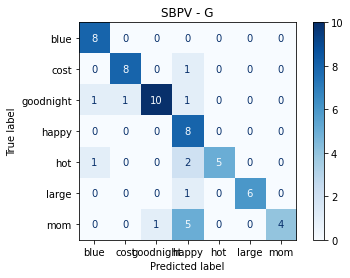

          ORL       ORL       ORL  ...       OYR       OYR       OYR
188  -1.24785  -1.24785  -1.24785  ...   1.15608   1.15608   1.15608
53  -0.412533 -0.412533 -0.447995  ...  -1.65368  -1.65368  -1.65368
180 -0.368547 -0.368547 -0.368547  ...   1.09887   1.07065   1.07065
52  -0.276007 -0.276007    -0.454  ...  -1.62875  -1.62875  -1.62875
39  -0.755279 -0.755279 -0.717172  ... -0.869599 -0.869599 -0.869599
..        ...       ...       ...  ...       ...       ...       ...
92  -0.418878 -0.418878 -0.418878  ...   1.39445   1.35818   1.32191
42  -0.957306  -1.03541  -1.03541  ... -0.957306 -0.957306 -0.957306
126  -1.07134  -1.07134  -1.07134  ...  0.543318  0.543318  0.543318
122  0.115378  0.083564  0.083564  ...  -1.95251  -1.95251  -1.95251
96   0.357243  0.388885   0.45217  ...  -1.85773  -1.85773  -1.82608

[147 rows x 300 columns]
[[-1.27599399e+01 -3.12874306e+00 -5.83304778e+00 ...  1.65552468e-02
  -1.91178186e-02 -5.55111512e-16]
 [ 1.07829638e+01 -1.31463836e+00 -2.2437

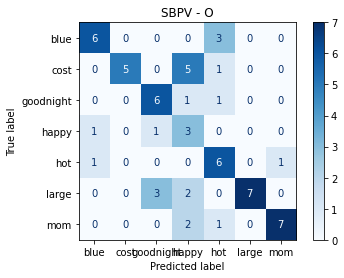

         EMG0L      EMG0L      EMG0L  ...       AZR       AZR       AZR
203  0.0196887 -0.0208868  0.0110421  ...  0.810402  0.528425   1.08712
173  0.0386176 -0.0409675   0.354074  ...   1.44623   1.45667   1.30186
142   0.013389 -0.0142038  -0.013169  ...  0.967566  0.802384  0.961416
86   0.0461317 -0.0489388   0.479969  ...   1.28986   1.29567   1.30148
130  0.0113353 -0.0120251   0.688748  ...   1.37297   1.35299   1.40517
..         ...        ...        ...  ...       ...       ...       ...
199  0.0577633 -0.0612783  -0.118593  ...   1.50051   1.45093   1.39438
155  0.0242762 -0.0257534  -0.168056  ...   1.62661   1.19321    1.4041
63   0.0442687 -0.0469625 -0.0753036  ...   1.39331   1.31112   1.31673
159  0.0533429 -0.0565889   -1.06936  ...   2.04168   1.07626  0.608461
11   0.0314924 -0.0334088  -0.500427  ...   1.11902   1.13056   1.16311

[147 rows x 1100 columns]
[[-4.18874207e+00 -5.56223248e+00  4.92387412e+00 ... -1.41800587e+00
  -1.98596958e+00  1.41553436e-15]
 [-6

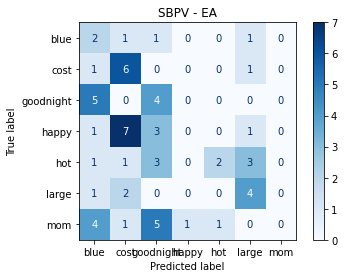

          EMG0L       EMG0L       EMG0L  ...        GZR         GZR         GZR
108   0.0439243  -0.0465971  -0.0432025  ...    -1.1039    -1.13621    -1.21791
169   0.0221293  -0.0234759  0.00275433  ...    2.11772     1.91742      1.8284
28    0.0394477  -0.0418481    0.228926  ...   -1.27837   -0.839518   -0.556639
125   0.0416108  -0.0441428   -0.138452  ...   0.127123     0.00397   -0.210796
207   0.0261357  -0.0277261  -0.0257062  ...  -0.183335  -0.0349411  -0.0598813
..          ...         ...         ...  ...        ...         ...         ...
67    0.0417754  -0.0443174   -0.184935  ... -0.0301141   -0.037465  0.00786541
192   0.0372784  -0.0395469   0.0435028  ...  0.0932853  0.00872096   0.0484144
138    0.026269  -0.0278675  -0.0549847  ...   -1.29781    -1.37522     -1.4941
33   0.00223976 -0.00237606  -0.0267483  ... -0.0458142  -0.0533099  -0.0467512
202   0.0182675  -0.0193791    -0.11105  ...   -1.37282   -0.919453    -0.82219

[147 rows x 1100 columns]
[[ 3.01222940

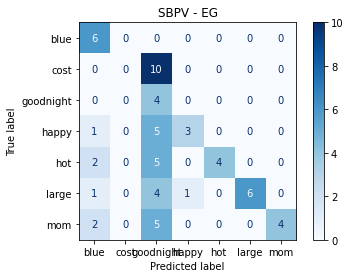

         EMG0L      EMG0L      EMG0L  ...        OYR        OYR        OYR
128   0.049012 -0.0519944   0.004995  ...   0.725525   0.725525   0.725525
204  0.0213222 -0.0226197 -0.0209718  ... -0.0138557 -0.0138557 -0.0138557
118  0.0119981 -0.0127282  0.0565155  ...    1.96629    1.96629    1.96629
6    0.0293423 -0.0311278 -0.0805646  ...  -0.481693  -0.363759  -0.324448
137   0.019366 -0.0205445 -0.0401264  ...  -0.447381  -0.561073  -0.674766
..         ...        ...        ...  ...        ...        ...        ...
199  0.0577633 -0.0612783  -0.118593  ...    1.22919    1.22919    1.22919
182  0.0196987 -0.0208974  -0.110467  ...    1.10448    1.07714    1.07714
147  0.0122775 -0.0130246 -0.0912854  ...   -1.80304   -1.80304    2.12154
74    0.040722    -0.0432  0.0982222  ...  -0.109504  -0.109504  -0.109504
29   0.0139596  -0.014809  0.0237452  ...  -0.746361  -0.666049  -0.625894

[147 rows x 1100 columns]
[[ 1.19838947e+01 -4.18056857e-01 -1.00922778e+01 ... -2.55683307e+00
  -

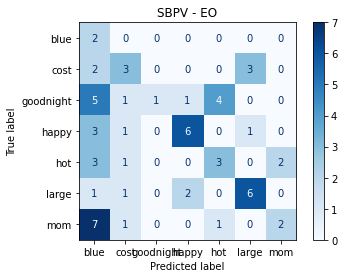

          AXL       AXL       AXL  ...         GZR         GZR        GZR
42  -0.721993 -0.588367 -0.294564  ...  -0.0186511  -0.0111946 -0.0141772
21  -0.843122 -0.860139 -0.784771  ...    -1.89893    -2.29768   -0.17043
153   -1.7783  -1.73852  -1.04989  ...  -0.0932119  -0.0588051 -0.0445388
87  -0.407171 -0.429516 -0.684774  ...  -0.0980477   -0.177031  -0.153054
0    -1.15242  -1.17237  -1.19316  ...   -0.643462    0.239765   0.379402
..        ...       ...       ...  ...         ...         ...        ...
159  -1.58131  -1.62752   -1.8335  ...    0.337659     0.22675   0.185762
186 -0.235085 -0.255808 -0.302187  ...  0.00201639 -0.00252318 -0.0286257
166 -0.640019 -0.230604 -0.425243  ...    0.198056    0.104125   0.118576
197 -0.607005 -0.629265 -0.609573  ...  -0.0494121   -0.765815   -0.51007
3   -0.103482 -0.134719 -0.135922  ...   -0.315691    0.261596  -0.262478

[147 rows x 600 columns]
[[-5.90538316e+00 -3.27300406e+00 -1.08243815e+00 ... -8.07795017e-03
  -5.33903575e-0

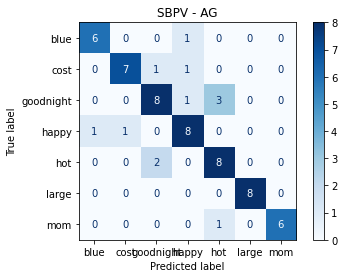

          AXL        AXL       AXL  ...       OYR       OYR       OYR
167  -0.67361   -0.67012 -0.713755  ...  -1.52201  -1.44614  -1.37027
120  -1.33558   -1.30345  -1.31648  ...   1.27895   1.27895   1.27895
35   -1.18337   -1.08154 -0.880738  ...  -2.06797  -2.06797  -2.06797
51   -1.00071   -1.12867  -1.20249  ...  -1.51077  -1.47944  -1.47944
12   -0.78111  -0.785058 -0.782097  ... -0.551974 -0.551974 -0.551974
..        ...        ...       ...  ...       ...       ...       ...
156  0.611563   0.408966  0.534971  ...  -2.38524  -2.35908  -2.33292
99   -1.73749   -1.76031  -1.98023  ...  0.495261  0.495261  0.495261
58   0.079026  0.0307838 -0.002487  ... -0.553219 -0.553219 -0.553219
200 -0.383115  -0.390041 -0.403026  ...   1.34487   1.31769   1.29051
76  -0.564489  -0.558255 -0.572503  ...   2.03814   1.95259   1.89556

[147 rows x 600 columns]
[[ 4.83754122e+00 -9.20806156e+00  5.21035193e+00 ... -4.55545829e-02
   1.62210626e-02  1.42941214e-15]
 [-3.48682460e+00 -3.12193533

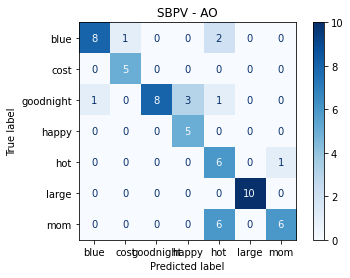

           GXL        GXL        GXL  ...       OYR       OYR       OYR
75    0.831632   0.831632   0.594709  ...  0.347844  0.347844  0.347844
18  -0.0788248  -0.086966 -0.0544012  ...    -2.368   -2.4486  -2.55608
150 -0.0219827  0.0303498 -0.0521404  ...   1.45805   1.42754   1.42754
42   -0.152868  -0.142429  -0.791144  ... -0.957306 -0.957306 -0.957306
119    2.13058    1.85676    1.09215  ...   2.04065   2.04065   2.04065
..         ...        ...        ...  ...       ...       ...       ...
63    -2.39603   -2.39603   -1.34036  ...  -1.65037  -1.65037  -1.65037
101  0.0308689  -0.308345   -0.21419  ... -0.377295 -0.377295 -0.377295
36     1.61338    1.80576    1.75436  ...   -2.0829   -2.0829   -2.0829
98     1.41297    1.31038  -0.410431  ...  0.329036  0.387307  0.387307
121 -0.0760188  -0.134371 -0.0639081  ...  0.919255  0.919255  0.919255

[147 rows x 600 columns]
[[-9.92207482e+00  7.91829004e+00  8.56264976e-02 ...  9.41043629e-02
  -2.06155991e-02  4.99600361e-16]
 [-2.

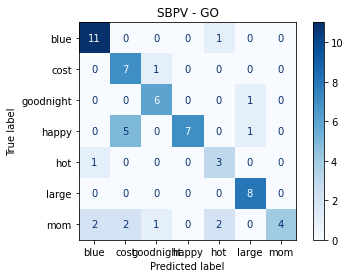

          EMG0L       EMG0L      EMG0L  ...        GZR        GZR         GZR
19    0.0274242   -0.029093  -0.131821  ...  -0.029412 -0.0326711  -0.0348439
18    0.0325553  -0.0345363 -0.0958542  ...   -1.69485    -2.5171    -3.19011
141   0.0537434  -0.0570137  -0.087702  ...  -0.213994  -0.197461   0.0328967
179   0.0287115  -0.0304586  -0.231807  ...   0.407253   0.308662  -0.0271194
54    0.0366915  -0.0389242  0.0698796  ... -0.0279778 -0.0513547  -0.0381417
..          ...         ...        ...  ...        ...        ...         ...
154 -0.00592548  0.00628605  -0.111945  ...    3.02939    2.12687     2.03298
67    0.0417754  -0.0443174  -0.184935  ... -0.0301141  -0.037465  0.00786541
69    0.0744663  -0.0789977 -0.0732427  ... -0.0900397  -0.119186   -0.127347
173   0.0386176  -0.0409675   0.354074  ...  -0.550735  -0.259138   -0.270875
82   0.00680263 -0.00721657  -0.177519  ... -0.0647774  -0.109656  -0.0969543

[147 rows x 1400 columns]
[[-3.45949194e+00 -4.14339897e+00 -3.

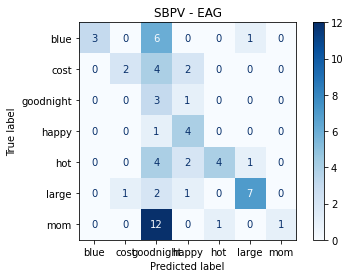

          EMG0L       EMG0L       EMG0L  ...       OYR       OYR       OYR
91    0.0269607  -0.0286013   -0.288099  ...   1.28512   1.28512   1.24819
150   0.0592885  -0.0628963   -0.468379  ...   1.45805   1.42754   1.42754
99    0.0178704  -0.0189578  -0.0913958  ...  0.495261  0.495261  0.495261
20    0.0281728  -0.0298872 -0.00198128  ...  -1.08317  -1.04127 -0.999384
83    0.0360295   -0.038222  -0.0128484  ...   -1.3298   -1.3298   -1.3298
..          ...         ...         ...  ...       ...       ...       ...
171   0.0296039  -0.0314053  -0.0727729  ...   1.02566   1.08557   1.20539
38    0.0247394  -0.0262448   0.0218012  ...  -0.89077  -0.89077  -0.89077
136    0.027564  -0.0292413  -0.0821016  ... -0.346949 -0.459717 -0.572485
82   0.00680263 -0.00721657   -0.177519  ...  -1.36394  -1.36394  -1.36394
107   0.0338644  -0.0359251  -0.0581626  ...   1.89936    1.8712   1.84303

[147 rows x 1400 columns]
[[-9.66517768e+00 -6.65192907e+00  1.31440818e+01 ... -5.31831247e-01
  -

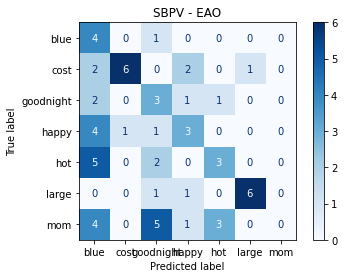

         EMG0L      EMG0L      EMG0L  ...       OYR       OYR       OYR
5    0.0214114 -0.0227143 -0.0425516  ...  -1.41737  -1.45497  -1.53016
164  0.0325368 -0.0345167    0.17505  ...  -1.31138  -1.24009  -1.24009
111   0.031879 -0.0338189 -0.0529133  ...   1.05354   1.38272    1.5238
209 -0.0189256  0.0200773  -0.045813  ...   2.10362   2.10362   2.10362
53   0.0299311 -0.0317524  -0.128933  ...  -1.65368  -1.65368  -1.65368
..         ...        ...        ...  ...       ...       ...       ...
51   0.0121739 -0.0129147 -0.0415761  ...  -1.51077  -1.47944  -1.47944
85   0.0436451 -0.0463009 -0.0021857  ...  -1.83249  -1.87386   -1.9566
173  0.0386176 -0.0409675   0.354074  ...   0.14676   0.14676   0.14676
9    0.0654389  -0.069421 -0.0643636  ... -0.689155 -0.689155 -0.689155
165   0.016279 -0.0172696  -0.163166  ...  -1.30895  -1.23315  -1.23315

[147 rows x 1400 columns]
[[ 1.67537453e+01 -6.80630391e+00  5.55426614e+00 ... -9.03195959e-01
  -1.37605912e+00  3.21964677e-15]
 [ 6

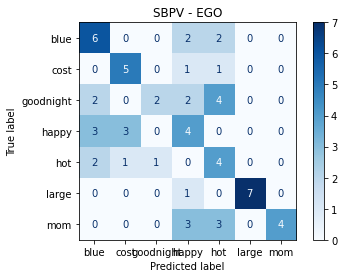

          AXL       AXL         AXL  ...       OYR       OYR       OYR
25  -0.405119 -0.405119   -0.405119  ... -0.466612 -0.602277  -0.67011
81   -1.32306   -1.3248    -1.39617  ...  -1.54282  -1.54282  -1.54282
117   -2.1525  -1.43258     -1.1455  ...   2.03416   2.03416   2.03416
55  -0.664238 -0.303614   -0.111498  ...  -1.70503  -1.70503  -1.70503
11   -1.18333  -1.18438    -1.18858  ... -0.873818 -0.873818 -0.873818
..        ...       ...         ...  ...       ...       ...       ...
10   -1.17622  -1.18888     -1.1583  ... -0.817478 -0.817478 -0.817478
94   -1.63017  -1.84464     -1.8508  ...  -1.92214  -1.92214  -1.92214
76  -0.564489 -0.558255   -0.572503  ...   2.03814   1.95259   1.89556
43  -0.257179 -0.128739 -0.00374703  ...  -1.03503  -1.03503  -1.03503
178  -0.48694 -0.334788  -0.0518391  ...   2.12686   2.12686   2.12686

[147 rows x 900 columns]
[[ 5.10899640e+00  4.71319639e+00 -3.45914975e+00 ... -3.40381855e-02
  -8.32561038e-03  1.64798730e-15]
 [ 2.59363765e+00

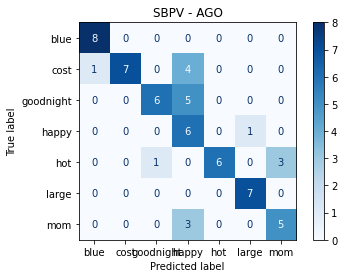

          EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
127   0.0526778  -0.0558833  -0.163595  ...  0.696832  0.659943  0.659943
27    0.0351107  -0.0372472 -0.0717371  ... -0.523361 -0.441629 -0.400762
82   0.00680263 -0.00721657  -0.177519  ...  -1.36394  -1.36394  -1.36394
200   0.0281807  -0.0298955 -0.0812677  ...   1.34487   1.31769   1.29051
129   0.0444205  -0.0471235 -0.0900827  ...  0.843806  0.843806  0.843806
..          ...         ...        ...  ...       ...       ...       ...
124    0.034875  -0.0369972  -0.135634  ...  -1.91271  -1.91271  -1.91271
49    0.0113047  -0.0119927 -0.0541847  ...  -1.56947  -1.56947  -1.56947
54    0.0366915  -0.0389242  0.0698796  ...   -1.6832   -1.6832  -1.71797
55    0.0392723  -0.0416621  0.0222014  ...  -1.70503  -1.70503  -1.70503
22      0.02344  -0.0248664 -0.0711987  ... -0.927243 -0.970013 -0.970013

[147 rows x 1700 columns]
[[-1.49943729e+01 -1.77880487e+00 -2.24338349e+00 ...  5.09532864e-01
  -2.31920648e+

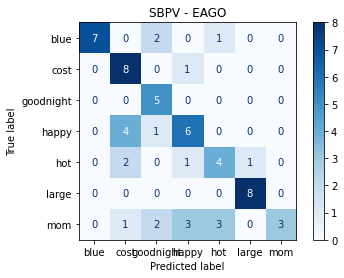

In [11]:
for st in steps:
  rownum+=1
  columnnum=-1
  for pr in regproducts:
    columnnum+=1
    combo=nsteps[rownum]+' - '+comb[columnnum]
    words=set(pr['Word']) # Obtain the target names for the SVM
    
    # First step: set input matrix as regular, normalized or standardized
    input_matrix=pr
    if st%3==0: # Normalization
      input_matrix=normproducts[columnnum]
    if st%5==0: # Standardization
      input_matrix=stanproducts[columnnum]
    
    # Second step: apply Butterworth
    two_matrix=input_matrix
    if st%7==0: # Butterworth
      two_matrix=butterworth(input_matrix)
    
    # Third step: split data for later steps
    x_train, x_test, y_train, y_test=datasplit(two_matrix)
    
    # Fourth step: apply PCA
    x_t_train=x_train
    x_t_test=x_test
    if st%11==0: # PCA
      x_train, x_test, y_train, y_test, x_t_train, x_t_test=pca(x_train, x_test, y_train, y_test)
    
    # Fifth step: apply SVM
    if st%13==0: # SVM
      #svmresults,accuracy,par=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
      svmresults,accuracy=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
    
    #print('The best parameters for',combo,'are:',par)
    fresults[rownum,columnnum]=accuracy*100
fresults=pd.DataFrame(fresults,index=nsteps,columns=comb)
exec("fresults.to_csv(path_or_buf='/content/results_'+str(numreps)+'.csv')")

endtime=time.time()

# **5. Results**

In [12]:
print(fresults)
print('The maximum accuracy for',numreps,'repetitions is',fresults.max().max())
print('The program executed in '+str(endtime-starttime)+' seconds')

              E          A          G  ...        EGO        AGO       EAGO
V     27.904762  39.857143  14.285714  ...  16.261905  31.833333  40.738095
NV     5.642857  33.428571  40.238095  ...  39.857143  35.785714  42.857143
SV     8.904762  21.619048  40.619048  ...   3.952381  41.023810  30.809524
BV    22.785714  28.976190  24.380952  ...  12.571429  35.380952  17.976190
PV    25.023810  37.976190  19.142857  ...   5.500000   7.476190   9.166667
NBV   26.857143  23.333333  37.761905  ...  16.261905  44.809524  25.166667
NPV   17.952381  56.738095  27.309524  ...  46.261905  47.809524  37.523810
SBV    9.166667  22.785714  39.333333  ...  23.738095  46.404762  24.142857
SPV   21.880952  44.833333  57.261905  ...  27.404762  59.119048  27.904762
BPV    7.214286  56.833333   5.380952  ...  10.880952   7.476190  11.023810
NBPV   7.071429  53.452381  43.095238  ...  48.095238  47.928571  46.928571
SBPV  14.452381  31.690476  43.523810  ...  27.261905  28.571429  40.738095

[12 rows x 